In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

root_path = '/Users/tc/Downloads/CS5260 Project/CS5260 Project Group'
data_path = root_path + '/data'
best_model_path = root_path + '/best_models'
output_path = root_path + '/outputs'

In [2]:
use_bert = True

# Feature Extraction
TODO:
1. Further clean spam emails that contain obvious content or metadata signaling that they are spam.

In [3]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
NO_EXPERIMENTS = 5

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Loop throught each csv file in the data folder
# Concat all dataframes into a single dataframe
# Create a new column called 'source' and store filename into it
# Save the dataframe to a new csv file in the data folder
dfs = []
for filename in os.listdir(data_path + '/cleaned'):
    if filename.endswith('kaggle.csv'):
        continue
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path + '/cleaned', filename))
        df.drop_duplicates(subset=['text', 'spam'], inplace=True)
        print(filename)
        print('Total:', df.shape[0], 'Non-spam:', df[df['spam'] == 0].shape[0], 'Spam:', df[df['spam'] == 1].shape[0])
        df['source'] = filename
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

ling.csv
Total: 2840 Non-spam: 2374 Spam: 466
assassin.csv
Total: 5757 Non-spam: 4203 Spam: 1554
enron.csv
Total: 28289 Non-spam: 14577 Spam: 13712


In [7]:
duplicate_emails = df[df.duplicated(subset='text', keep=False)]
duplicate_emails.sort_values(by='text')

,text,original_text,spam,source


In [8]:
duplicate_emails['source'].value_counts()

Series([], Name: count, dtype: int64)

In [9]:
print('Before dropping duplicate emails:', df.shape[0])
df.drop_duplicates(subset=['text'], inplace=True)
print('After dropping duplicate emails:', df.shape[0])

Before dropping duplicate emails: 36886
After dropping duplicate emails: 36886


In [10]:
df = df[~df['text'].str.contains('html body', na=False)]
df.shape

(36868, 4)

In [11]:
df = df[~df['text'].isna()]
df.shape

(36868, 4)

In [12]:
df['spam'].value_counts()

spam
0    21154
1    15714
Name: count, dtype: int64

In [13]:
df.to_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'), index=False)

In [14]:
if use_bert:
    df = df[['original_text', 'spam']].copy()
    df.columns = ['text', 'spam']
else:
    df = df[['text', 'spam']].copy()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['spam'], test_size=0.1, random_state=42)

In [16]:
df.shape, X_train.shape, X_val.shape

((36868, 2), (33181,), (3687,))

In [17]:
y_val[y_val == 0].shape, y_val[y_val == 1].shape

((2062,), (1625,))

In [18]:
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(X_train)
train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

dump(vectorizer, os.path.join(root_path, 'tfidf_vectorizer.joblib'))

['/Users/tc/Downloads/CS5260 Project/CS5260 Project Group/tfidf_vectorizer.joblib']

# Datasets & Loaders

## TF-IDF

In [19]:
class TFIDFDataset(Dataset):
    def __init__(self, features_df, labels_df):
        self.features = torch.tensor(features_df.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels_df.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [20]:
val_tfidf_df = pd.DataFrame(vectorizer.transform(X_val).toarray(), columns=vectorizer.get_feature_names_out())

In [21]:
BATCH_SIZE = 256

train_loader = DataLoader(TFIDFDataset(train_tfidf_df, y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TFIDFDataset(val_tfidf_df, y_val), batch_size=BATCH_SIZE, shuffle=False)

# Models

## DistilBert

In [34]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U
%pip install datasets

  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 17.1 MB/s eta 0:00:00
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 36.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━

In [52]:
from transformers import AutoTokenizer, DistilBertForTokenClassification, TFDistilBertForTokenClassification, DistilBertTokenizer
from datasets import Dataset
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction
import numpy as np

In [62]:

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
val_df = pd.DataFrame({'text': X_val, 'labels': y_val})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Function to tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/33181 [00:00<?, ? examples/s]

Map:   0%|          | 0/3687 [00:00<?, ? examples/s]

In [63]:
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DistilBertForSequenceClassification, DistilBertModel
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, return_dict=True)
# model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=2, return_dict=True)


def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    # max_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,

    logging_dir="./logs",
    logging_steps=10,

    evaluation_strategy='steps',
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./distilbert")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
1000,0.037200,0.140251,0.967996
2000,0.180400,0.092315,0.978031
3000,0.219900,0.047740,0.990507
4000,0.009300,0.045543,0.989965


In [65]:
distilbert = DistilBertForSequenceClassification.from_pretrained("./distilbert", num_labels=2)
distilbert.to(device)
distilbert.name = 'distilbert'

In [42]:
%pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [68]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

distilbert_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
distilbert_val_loader = DataLoader(val_dataset, batch_size=16)

batch = next(iter(distilbert_val_loader))
batch

{'labels': tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]),
 'input_ids': tensor([[  101,  2489, 16746,  ...,     0,     0,     0],
         [  101,  2123,  1005,  ...,     0,     0,     0],
         [  101,  4357,  2007,  ...,     0,     0,     0],
         ...,
         [  101,  6975,  4106,  ...,     0,     0,     0],
         [  101,  3036,  1011,  ...,     0,     0,     0],
         [  101,  1000, 17394,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

# Adversarial Attacks
1. The norm ball perturbation they consider, and
2. the method they use for optimizing over that norm ball.

- FGSM is simply a single projected gradient descent step under the ℓ∞ constraint.
- It assumes that the linear approximation, given by its gradient at the point x, is a reasonably good approximation to the function over the entire region where \(\|\delta\|_\infty \leq \epsilon\). However, this assumption also hints at the potential disadvantages of the FGSM attack: because we understand that neural networks are, in fact, not linear, even over relatively small regions. Therefore, if we desire a stronger attack, we likely need to consider more effective methods of maximizing the loss function than a single projected gradient step.

### ALBERT

In [58]:
def fgsm_distilbert(model, data, eps=0.01, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids)

    delta = torch.zeros_like(embeddings, requires_grad=True)
    perturbed_embeddings = embeddings + delta

    outputs = model(inputs_embeds=perturbed_embeddings,
                    attention_mask=data['attention_mask'].to(device),
                    labels=labels)

    loss = outputs.loss
    model.zero_grad()
    loss.backward()

    perturbed_delta = eps * delta.grad.detach().sign()
    perturbed_embeddings = embeddings + perturbed_delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return perturbed_delta, perturbed_embeddings, correct_predictions, 1
    return perturbed_delta, perturbed_embeddings, correct_predictions

def run_distilbert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy


In [67]:
def fgsm_distilbert(model, data, eps=0.01, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids)

    delta = torch.zeros_like(embeddings, requires_grad=True)
    perturbed_embeddings = embeddings + delta

    outputs = model(inputs_embeds=perturbed_embeddings,
                    attention_mask=data['attention_mask'].to(device),
                    labels=labels)

    loss = outputs.loss
    model.zero_grad()
    loss.backward()

    perturbed_delta = eps * delta.grad.detach().sign()
    perturbed_embeddings = embeddings + perturbed_delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return perturbed_delta, perturbed_embeddings, correct_predictions, 1
    return perturbed_delta, perturbed_embeddings, correct_predictions

def run_distilbert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy


In [59]:
epsilons = [0.01, 0.1, 1.0]
accuracies = []
for eps in epsilons:
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=fgsm_distilbert, opt=None, description='ALBERT', eps=eps)
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

NameError: name 'albert' is not defined

In [70]:
epsilons = [0.01, 0.1, 1.0]
accuracies = []
for eps in epsilons:
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=fgsm_distilbert, opt=None, description='DISTILBERT', eps=eps)
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

DISTILBERT: 100%|██████████████████████████████████████████████████████████████████████████████████████| 231/231 [27:29<00:00,  7.14s/it]


,epsilon,accuracy
0,0.01,0.353675
1,0.10,0.178465
2,1.00,0.167887


## Projected Gradient Descent

The average absolute value of the gradient for any given feature is around 10^-5 at the initial zero point, necessitating scaling by a relatively large α to make any progress. Once we "break out" of the initial region around δ=0, the gradients typically increase substantially in magnitude. At this point, our large α becomes excessive, causing the method to take too large a step toward the boundary, effectively acting like FGSM.

### PGD Infinity Norm

In [71]:
def pgd_linf(model, X, y, eps=0.0005, alpha=0.00005, num_iter=50, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

In [73]:
def pgd_linf_distilbert(model, data, eps=0.1, alpha=0.01, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_linf_distilbert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [31:00<00:00,  8.05s/it]


,epsilon,accuracy
0,0.001,0.965012
1,0.010,0.242474
2,0.100,0.035801


In [75]:
epsilons = [0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_linf_distilbert, opt=None, description='DISTILBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

DISTILBERT: 100%|████████████████████████████████████████████████████████████████████████████████████| 231/231 [1:42:55<00:00, 26.73s/it]


,epsilon,accuracy
0,0.001,0.970165
1,0.010,0.279631
2,0.100,0.045837


### PGD Infinity Norm with Random Restarts

The performance of PGD is still constrained by the potential presence of local optima within the objective. Although it's impossible to completely eliminate the occurrence of local optima, we can somewhat alleviate this issue through random restarts.

In [ ]:
def pgd_linf_rand(model, X, y, eps=0.0005, alpha=0.00005, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


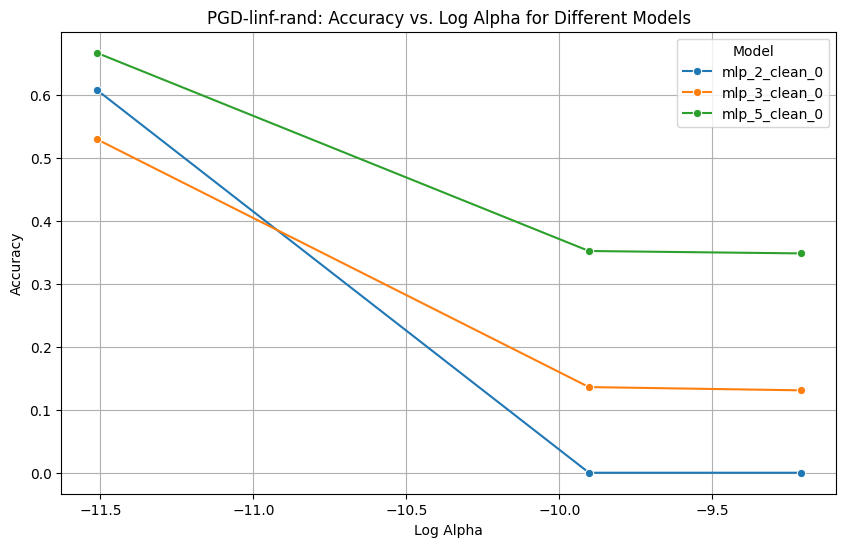

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00001,0.607811,-11.512925
1,mlp_2_clean_0,0.00005,0.000000,-9.903488
2,mlp_2_clean_0,0.00010,0.000000,-9.210340
3,mlp_3_clean_0,0.00001,0.529428,-11.512925
4,mlp_3_clean_0,0.00005,0.135883,-9.903488
5,mlp_3_clean_0,0.00010,0.130730,-9.210340
6,mlp_5_clean_0,0.00001,0.666395,-11.512925
7,mlp_5_clean_0,0.00005,0.351777,-9.903488
8,mlp_5_clean_0,0.00010,0.347979,-9.210340


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [10]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

### PGD L2 Norm

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10


def pgd_l2(model, X, y, eps=1.0, alpha=1.0/20, num_iter=50, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
        delta.data *= eps / norms(delta.detach()).clamp(min=eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


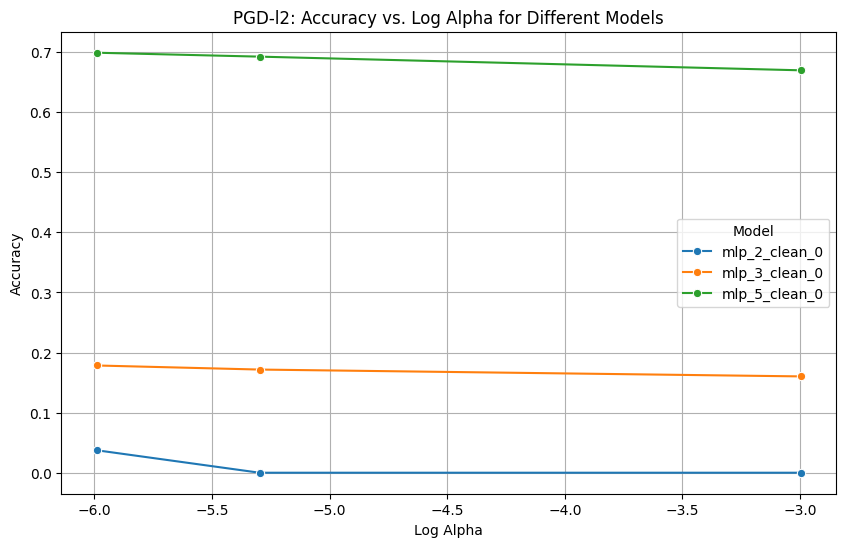

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.0025,0.037429,-5.991465
1,mlp_2_clean_0,0.0050,0.000000,-5.298317
2,mlp_2_clean_0,0.0500,0.000000,-2.995732
3,mlp_3_clean_0,0.0025,0.178465,-5.991465
4,mlp_3_clean_0,0.0050,0.171684,-5.298317
5,mlp_3_clean_0,0.0500,0.160293,-2.995732
6,mlp_5_clean_0,0.0025,0.698942,-5.991465
7,mlp_5_clean_0,0.0050,0.692433,-5.298317
8,mlp_5_clean_0,0.0500,0.669650,-2.995732


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.1, 1.0]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [76]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10

def pgd_l2_distilbert(model, data, eps=1.0, alpha=0.1, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta *= eps / norms(delta.detach()).clamp(min=eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_l2_distilbert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [30:59<00:00,  8.05s/it]


,epsilon,accuracy
0,0.01,0.950095
1,0.10,0.229184
2,1.00,0.059940


In [78]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_l2_distilbert, opt=None, description='DISTILBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

DISTILBERT: 100%|████████████████████████████████████████████████████████████████████████████████████| 231/231 [1:37:34<00:00, 25.34s/it]


,epsilon,accuracy
0,0.01,0.956604
1,0.10,0.246271
2,1.00,0.045294


### PGD L2 Norm with Random Restarts

In [ ]:
def pgd_l2_rand(model, X, y, eps=1.0, alpha=1.0/20, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta.data *= eps / norms(delta.detach()).clamp(min=eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:52<00:00,  7.50s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:51<00:00,  7.46s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:47<00:00,  7.20s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:50<00:00,  7.37s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:48<00:00,  7.20s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:50<00:00,  7.36s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:50<00:00,  7.33s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it]


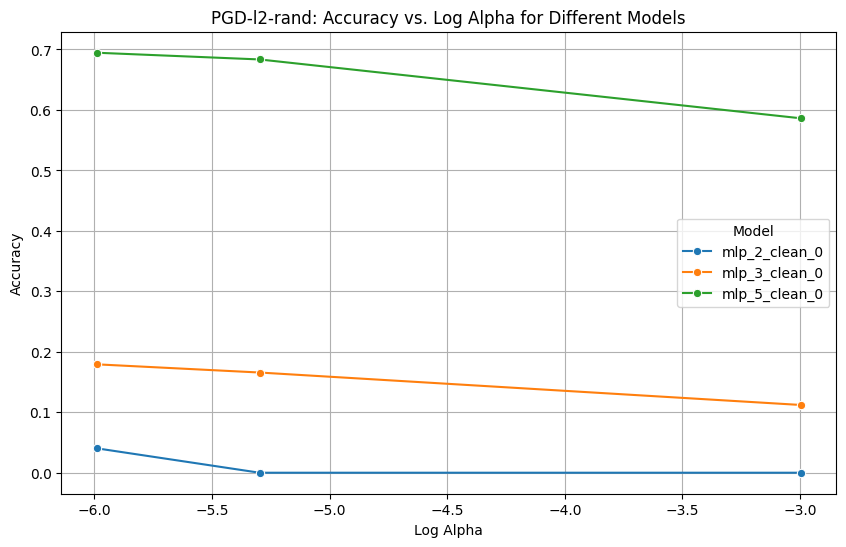

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.0025,0.040412,-5.991465
1,mlp_2_clean_0,0.0050,0.000000,-5.298317
2,mlp_2_clean_0,0.0500,0.000000,-2.995732
3,mlp_3_clean_0,0.0025,0.179279,-5.991465
4,mlp_3_clean_0,0.0050,0.165717,-5.298317
5,mlp_3_clean_0,0.0500,0.112015,-2.995732
6,mlp_5_clean_0,0.0025,0.694603,-5.991465
7,mlp_5_clean_0,0.0050,0.683483,-5.298317
8,mlp_5_clean_0,0.0500,0.586113,-2.995732


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.1, 1.0]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

## Targeted Attacks
In targeted attacks, we maximize the loss associated with the true label while also minimizing the loss for the alternative label.

In [ ]:
def pgd_linf_targ(model, X, y, eps=0.0001, alpha=0.00001, num_iter=50, y_targ=0, return_query_count=False):
    model.eval()

    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = (yp[:, y_targ].unsqueeze(1) - yp.gather(1, y.long()[:, None])).sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


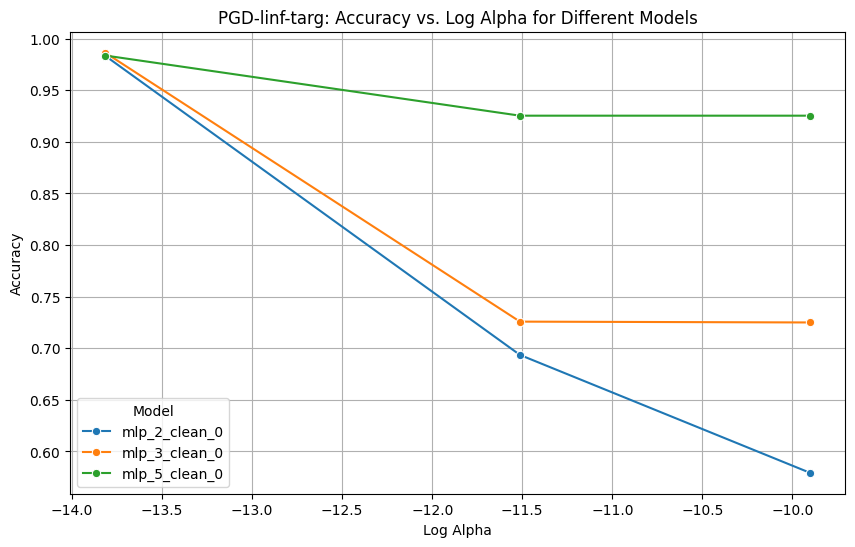

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000001,0.983455,-13.815511
1,mlp_2_clean_0,0.000010,0.693518,-11.512925
2,mlp_2_clean_0,0.000050,0.579333,-9.903488
3,mlp_3_clean_0,0.000001,0.986439,-13.815511
4,mlp_3_clean_0,0.000010,0.725793,-11.512925
5,mlp_3_clean_0,0.000050,0.724980,-9.903488
6,mlp_5_clean_0,0.000001,0.983727,-13.815511
7,mlp_5_clean_0,0.000010,0.925414,-11.512925
8,mlp_5_clean_0,0.000050,0.925414,-9.903488


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.00001, 0.0001, 0.0005]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [80]:
def pgd_linf_targ_distilbert(model, data, eps=0.1, alpha=0.01, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = (logits[:, y_targ] - logits.gather(1, labels[:,None])[:,0]).sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_linf_targ_distilbert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [30:20<00:00,  7.88s/it]


,epsilon,accuracy
0,0.01,0.611066
1,0.10,0.583130
2,1.00,0.668836


In [81]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_linf_targ_distilbert, opt=None, description='DISTILBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

DISTILBERT:  84%|██████████████████████████████████████████████████████████████████████▏             | 193/231 [1:32:46<18:15, 28.84s/it]


KeyboardInterrupt: 

In [ ]:
def pgd_linf_targ2(model, X, y, eps=0.0005, alpha=0.0005/20, num_iter=40, y_targ=0, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = 2 * yp[:, y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0075, Alpha: 0.0004: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0075, Alpha: 0.0004: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Mo

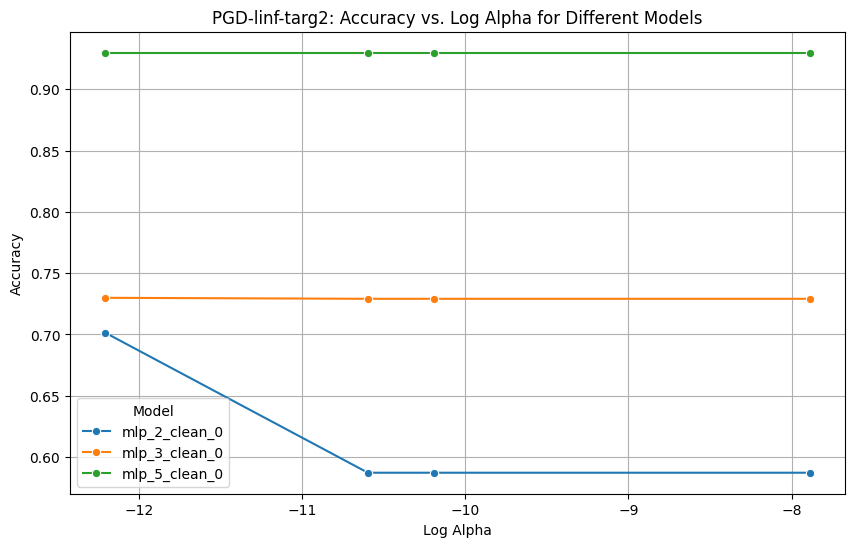

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000005,0.701383,-12.206073
1,mlp_2_clean_0,0.000025,0.587198,-10.596635
2,mlp_2_clean_0,0.000038,0.587198,-10.191170
3,mlp_2_clean_0,0.000375,0.587198,-7.888585
4,mlp_3_clean_0,0.000005,0.729862,-12.206073
5,mlp_3_clean_0,0.000025,0.729048,-10.596635
6,mlp_3_clean_0,0.000038,0.729048,-10.191170
7,mlp_3_clean_0,0.000375,0.729048,-7.888585
8,mlp_5_clean_0,0.000005,0.929753,-12.206073
9,mlp_5_clean_0,0.000025,0.929753,-10.596635


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.00075, 0.0075]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [91]:
def pgd_linf_targ2_distilbert(model, data, eps=1.0, alpha=0.1, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()
    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = 2 * logits[:, y_targ].sum() - logits.sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_distilbert_epoch(distilbert, distilbert_val_loader, attack=pgd_linf_targ2_distilbert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [31:00<00:00,  8.06s/it]


,epsilon,accuracy
0,0.01,0.621915
1,0.10,0.579333
2,1.00,0.539463


## Ensemble

In [ ]:
def ensemble_attack(model, inputs, labels, child_attacks, return_query_count=False):
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        if return_query_count:
            deltas, query_count = attack(model, inputs, labels, return_query_count=True)
            total_query_count += query_count
        else:
            deltas = attack(model, inputs, labels, return_query_count=False)

        if avg_deltas is None:
            avg_deltas = deltas
        else:
            avg_deltas += deltas
    avg_deltas /= len(attacks)

    if return_query_count:
        return avg_deltas, total_query_count
    return avg_deltas

[Valid] Model: mlp_5: 100%|██████████| 15/15 [04:38<00:00, 18.53s/it]


,model,accuracy
0,mlp_2,0.000542
1,mlp_3,0.086249
2,mlp_5,0.431516


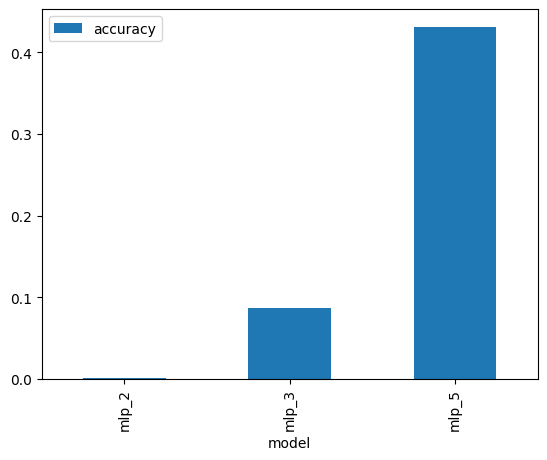

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]
models = [model_mlp_2, model_mlp_3, model_mlp_5]

accuracies = []

for model in models:
    accuracy, loss = run_epoch(model, valid_loader, attack=ensemble_attack, child_attacks=attacks,
                               description=f"[Valid] Model: {model.name}")

    accuracies.append({'model': model.name, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df.plot(x='model', y='accuracy', kind='bar')

accuracies_df

## Crafting Adversarial Emails in Word Space

In [ ]:
attacks = [
    # pgd_linf_targ2,
    # pgd_linf_targ,
    pgd_l2,
    # pgd_l2_rand,
    # pgd_linf,
    # pgd_linf_rand,
    # fgsm
]

attack_name = 'pgd_l2'
model = model_mlp_5
model.eval()

MLP(
  (blocks): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=24823, out_features=200, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): MLPBlock(
      (linear): Linear(in_features=200, out_features=100, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): MLPBlock(
      (linear): Linear(in_features=100, out_features=50, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): MLPBlock(
      (linear): Linear(in_features=50, out_features=25, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=25, out_features=1, bias=True)
)

### Crafting Adversarial Vocabulary

In [ ]:
y_spam_train = y_train[y_train == 1]
X_spam_train = X_train[y_train == 1]

train_spam_tfidf_df = pd.DataFrame(vectorizer.transform(X_spam_train).toarray(), columns=vectorizer.get_feature_names_out())
train_spam_loader = DataLoader(TFIDFDataset(train_spam_tfidf_df, y_spam_train), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_delta_list = []

def wrap_attack(model, inputs, labels):
    avg_deltas = ensemble_attack(model, inputs, labels, attacks)

    train_delta_list.append(avg_deltas.cpu().detach().numpy())

    return avg_deltas

accuracy, loss = run_epoch(model, train_spam_loader, attack=wrap_attack,
                           description=f"Model: {model.name}")

train_deltas_df = pd.DataFrame(np.vstack(train_delta_list))

assert train_deltas_df.shape[0] == X_spam_train.shape[0]
assert train_deltas_df.shape[1] == train_tfidf_df.shape[1]

Model: mlp_5: 100%|██████████| 49/49 [00:11<00:00,  4.34it/s]


The key high-level element to note here is that while ℓ∞ attacks result in small noise distributed uniformly across the features (precisely because this type of perturbation is allowable under the ℓ∞ ball), ℓ2 attacks lead to perturbations that are more localized within the image. This occurs because we can "trade off" a larger perturbation at one point in the space for a smaller perturbation at another.

ℓ1 attacks, by the nature of the ℓ1 norm, encourage sparsity in the δ perturbation, i.e., they will have only a few features that are adjusted.

TODO:
1. Emperically compare l-inf and l2

In [ ]:
train_deltas_df.columns = train_tfidf_df.columns

In [ ]:
means = train_deltas_df.mean(axis=0)
top = int(train_deltas_df.shape[1] * 0.1)
top_means = means.sort_values(ascending=False).head(top)
to_insert_vocabulary = top_means.index.tolist()

In [ ]:
to_insert_vocabulary[0:5]

['ron', 'vince', 'louise', 'wrote', 'en']

### Computing Token Importance

In [ ]:
def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [index for index in indices if index is not None]

def compute_token_importance(model, vectorizer, spam_sample):
    tfidf_sample = vectorizer.transform([spam_sample])
    df_sample = pd.DataFrame(tfidf_sample.toarray(), columns=vectorizer.get_feature_names_out())
    tensor_sample = torch.tensor(df_sample.to_numpy()).float().to(device)
    label_sample = torch.tensor([1]).float().to(device)

    indices = find_indices(spam_sample.split(), vectorizer.get_feature_names_out())

    to_replace = []
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        delta, query_count = attack(model, tensor_sample, label_sample, return_query_count=True)
        total_query_count += query_count
        if avg_deltas is None:
            avg_deltas = delta.cpu().detach().numpy()
        else:
            avg_deltas += delta.cpu().detach().numpy()
    avg_deltas /= len(attacks)

    to_replace.extend([(vectorizer.get_feature_names_out()[idx], avg_deltas[0, idx]) for idx in indices if avg_deltas[0, idx] < 0])
    to_replace = sorted(to_replace, key=lambda x: x[1])

    return to_replace, total_query_count

### GPT Replacement Attack (Attempt 2)


In [87]:
%pip install openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached openai-1.23.2-py3-none-any.whl.metadata (21 kB)
  Using cached pydantic-2.7.0-py3-none-any.whl.metadata (103 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
Using cached openai-1.23.2-py3-none-any.whl (311 kB)
Using cached pydantic-2.7.0-py3-none-any.whl (407 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00a 0:00:01
Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


In [88]:
from openai import OpenAI

client = OpenAI(
    api_key='',
)

def get_completion(prompt, model="gpt-4-0125-preview", temperature=0):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content

In [173]:
attacks = [
    pgd_linf_targ2_distilbert,
    # pgd_linf_targ_distilbert,
    pgd_l2_distilbert,
    # pgd_linf_distilbert,
]

# attack_name = 'distilbert_pgd_linf_targ_cleaned'
# attack_name = 'distilbert_pgd_l2_cleaned'
attack_name = 'distilbert_pgd_linf_targ2_l2_cleaned'

model = distilbert

model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [94]:
val_spam_df = X_val[y_val == 1].copy()
val_spam_df.reset_index(drop=True, inplace=True)
val_spam_df.shape

(1625,)

In [95]:
val_spam_df = pd.DataFrame({'text': val_spam_df, 'labels': [1] * val_spam_df.shape[0]})
val_spam_dataset = Dataset.from_pandas(val_spam_df)
val_spam_dataset = val_spam_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1625 [00:00<?, ? examples/s]

In [170]:

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = distilbert

def transform_to_distilbert_input(sample):
    inputs = tokenizer(sample, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    return inputs

def predict(sample, model, label=1):
    inputs = tokenizer(sample, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    probabilities = torch.softmax(logits, dim=-1)

    return probabilities[label].item()

predict('disappointed with your finances supervisor ? dues too high ? has your mutual fund or finances manager failed to provide the conclusions you expected ? efficient market portfolios are the lower cost alternative ! gratis tailored asset allocation recommendation . competently managed accounts using low cost , tax efficient exchange traded finances ( etf \' s ) for more data hit here feel without charge to communication us at data  efficient - portfolios . com or call us toll without charge at 1 - 888 - 327 - 4600 efficient market advisors , llc 12707 high buff drive , suite 200 san diego , ca 92130', model)

0.9997132420539856

In [174]:
import copy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

filter_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost',
                'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another',
                'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as',
                'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides',
                'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn',
                "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere',
                'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'first', 'for',
                'former', 'formerly', 'from', 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'he', 'hence',
                'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his',
                'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's",
                'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn',
                "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly', 'must', 'mustn', "mustn't", 'my', 'myself',
                'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none',
                'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only',
                'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per',
                'please', 's', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow',
                'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
                'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein',
                'thereupon', 'these', 'they', 'this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too',
                'toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used', 've', 'was', 'wasn', "wasn't",
                'we', 'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where',
                'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while',
                'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won',
                "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've",
                'your', 'yours', 'yourself', 'yourselves']
filter_words = set(filter_words)

def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [(i, index) for i, index in enumerate(indices) if index is not None]

def compute_token_importance(model, spam_sample):
    to_replace = []
    avg_deltas = None
    total_query_count = 0

    attention_mask = spam_sample['attention_mask'].squeeze()
    token_length = attention_mask.sum()

    for attack in attacks:
        delta, perturbed_embeddings, correct_predictions, query_count = attack(model, spam_sample, return_query_count=True)
        total_query_count += query_count
        if avg_deltas is None:
            avg_deltas = delta.cpu().detach()
        else:
            avg_deltas += delta.cpu().detach()
    avg_deltas /= len(attacks)

    important_values = None
    mean_abs_values = torch.mean(torch.abs(avg_deltas.squeeze()), dim=-1)
    important_values = [(value, pos) for value, mask, pos in zip(mean_abs_values, attention_mask, range(token_length)) if mask]
    important_values = sorted(important_values, key=lambda x: -x[0])

    decoded_text = tokenizer.decode(spam_sample['input_ids'].squeeze(), skip_special_tokens=True, clean_up_tokenization_spaces=True)

    tokens = tokenizer.convert_ids_to_tokens(spam_sample['input_ids'].squeeze())
    tokens = [token for token, mask in zip(tokens, attention_mask) if mask]

    assert max([value for value, pos in important_values]) > min([value for value, pos in important_values])
    assert attention_mask.sum() == len(tokens)
    assert attention_mask.sum() == len(important_values)
    return important_values, tokens, decoded_text, attention_mask, total_query_count

email_id = 1000
spam_sample = {}

spam_sample['labels'] = torch.tensor(1).unsqueeze(0).to(device)
spam_sample['input_ids'] = torch.tensor(val_spam_dataset[email_id]['input_ids']).unsqueeze(0).to(device)
spam_sample['attention_mask'] = torch.tensor(val_spam_dataset[email_id]['attention_mask']).unsqueeze(0).to(device)

important_values, tokens, decoded_text, attention_mask, total_query_count = compute_token_importance(model, spam_sample)
print(important_values[2])
print(tokens[important_values[2][1]])
text = val_spam_dataset[email_id]['text']
print(text)

(tensor(0.2570), 144)
june
request for mutually benefitting endeavour . owolabi & associate , falomo , ikoyi . lagos - nigeria . your kind attn . , re : request for mutually benefitting endeavour . i humbly crave your indulgence in sending you this mail , if the contents does not meet with your personal and business ethics , i apologize in advance . i am barrister kola owolabi ( attorney at law ) , i represent alhaji ishmaila ibrahim gwarzo   s estates . alhaji gwarzo was the chief security advicer of the then military leader of this country ( nigeria ) in the person of late general sani abacha who died on the 8 th of june 1998 . with the advent of a new democratic dispensation in the country under the leadership of gen . olusegun obasanjo ( rtd ) , my client has come under severe persecution due to the sensitive position he held in the last military regime , presently he is under house arrest restricted only to the confines of his village . the main purpose of this mail is to intimate

In [162]:
def top_k_candidates_2(spam_sample, important_words, k=3, model='gpt-4-0125-preview', attempt=0):
    prompt = f'''
        For each word in the word list, find the top {k} synonyms (words or phrases) that meet these three conditions:
        - Replacing occurrences of the word in the text with them does not alter the meaning and grammar of the text.
        - Sort the top {k} synonyms by decreasing relevance score within the text's context. The higher the score, the more relevant a replacement word is to the text.

        Format as "word: replacement words" in a single line. Wrap all lines in between a single pair "<<<" and ">>>".

        Text:
        {spam_sample}

        Word list:
        {important_words}
    '''

    # print(prompt)

    response = get_completion(prompt).strip()
    m = re.search(r'<<<(.*?)>>>', response, re.DOTALL)
    # Extract the first pair of text if found
    extracted_text = m.group(1).strip() if m else "No text found"
    if extracted_text == 'No text found':
        # print(response)
        if attempt < 3:
            return top_k_candidates_2(spam_sample, important_words, k=k, model=model, attempt=attempt+1)
        else:
            return {}, response

    lines = extracted_text.splitlines()
    substitutes = {}
    for line in lines:
        if line.strip() == '':
            continue

        if len(line.split(':')) < 2:
            # print(line)
            continue

        word = line.split(':')[0].strip()
        replacements = line.split(':')[1].strip().split(',')
        replacements = [r.strip() for r in replacements]

        substitutes[word] = replacements

    return substitutes, response

def create_sample_from_tokens(tokens):
    sample = ''
    for token in tokens[1 : len(tokens) - 1]:
        if token.startswith('##'):
            sample += token[2:]
        else:
            sample += ' ' + token
        # if token.startswith('▁'):
        #     sample += ' ' + token[1:]
        # elif not token.startswith('<') and not token.startswith('['):
        #     sample += token
        # else:
        #     continue

    return sample

def replace_attack(model, spam_sample, k=2, important_word_size=2):
    change_count = 0
    total_query_count = 0
    replacements = []
    random_attack = False

    important_values, tokens, decoded_text, attention_mask, query_count = compute_token_importance(model, spam_sample)
    total_query_count += query_count
    token_count = len(tokens)

    # print(spam_sample)
    print(len(important_values))
    assert len(important_values) > 0
    # print(tokens[important_values[0][1]])
    # print(tokens[important_values[1][1]])
    # print(tokens[important_values[2][1]])
    # print(tokens[important_values[3][1]])
    # return

    important_values = important_values[:important_word_size]
    # print(tokens[important_values[0][1]])
    # print(tokens[important_values[1][1]])
    # print(tokens[important_values[2][1]])
    # print(tokens[important_values[3][1]])
    # return

    processed_important_words = []
    # print(important_values)
    for _, pos in important_values:
        important_word = tokens[pos]
        # print(str(pos) + ": " + important_word)
        
        # if not important_word.startswith('▁') and not important_word.startswith('<') and not important_word.startswith('['):
        #     for i in range(pos - 1, -1, -1):
        #         if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
        #             important_word = tokens[i] + important_word
        #             tokens[i] = ''
        #         elif tokens[i].startswith('▁'):
        #             important_word = tokens[i] + important_word
        #             tokens[i] = ''
        #             break

        #     for i in range(pos + 1, len(tokens)):
        #         if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
        #             important_word += tokens[i]
        #             tokens[i] = ''
        #         elif tokens[i].startswith('▁'):
        #             break

        # if important_word.startswith('▁'):
        #     for i in range(pos + 1, len(tokens)):
        #         if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
        #             important_word += tokens[i]
        #             tokens[i] = ''
        #         elif tokens[i].startswith('▁'):
        #             break

        # print(str(pos) + ": " + important_word)
        # tokens[pos] = important_word
        processed_important_words.append((important_word, pos))

    # print(processed_important_words)
    # return
    # processed_important_words = [(target_word, pos) for target_word, pos in processed_important_words if re.compile(r"^[A-Za-z][\w'-]*$").match(target_word[1:])]
    processed_important_words = [(target_word, pos) for target_word, pos in processed_important_words if re.compile(r"^[A-Za-z][\w'-]*$").match(target_word)]
    # print(processed_important_words)
    # return
    # word_predictions, gpt_response = top_k_candidates_2(decoded_text, [w[1:] for w, _ in processed_important_words], k=k)
    word_predictions, gpt_response = top_k_candidates_2(decoded_text, [w for w, _ in processed_important_words], k=k)
    # print(word_predictions)
    # return

    original_prob = predict(decoded_text, model)
    adversarial_tokens = []
    best_prob = 1.0
    for target_word, pos in processed_important_words:
        # target_word = target_word[1:]
        # print("target_word: " + target_word)
        if target_word in ENGLISH_STOP_WORDS:
            continue

        if target_word in filter_words:
            continue

        substitutes = word_predictions.get(target_word, [])
        if len(substitutes) == 0:
            continue

        # print("substitutes: ")
        # print(substitutes)
        candidate = None
        for substitute in substitutes:
            if substitute == target_word:
                continue

            if substitute in ENGLISH_STOP_WORDS:
                continue

            if substitute in filter_words:
                continue

            # adversarial_tokens = tokens[:pos] + ['▁' + substitute] + tokens[pos + 1:]
            original_sample = create_sample_from_tokens(tokens)
            # print("original_sample: " + original_sample)
            adversarial_tokens = tokens[:pos] + [substitute] + tokens[pos + 1:]
            adversarial_sample = create_sample_from_tokens(adversarial_tokens)

            # print("adversarial_sample: " + adversarial_sample)
            # return

            prob = predict(adversarial_sample, model)
            total_query_count += 1

            if prob < 0.5:
                change_count += 1
                replacements.append((pos, target_word, substitute))
                tokens[pos] = '▁' + substitute
                print('Successful!')
                return decoded_text, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, prob, gpt_response
            else:
                if prob < best_prob:
                    best_prob = prob
                    candidate = substitute

        if candidate:
            change_count += 1
            replacements.append((pos, target_word, candidate))
            # adversarial_tokens = tokens[:pos] + ['▁' + candidate] + tokens[pos + 1:]
            # tokens[pos] = '▁' + candidate
            adversarial_tokens = tokens[:pos] + [candidate] + tokens[pos + 1:]
            tokens[pos] = candidate

    print('Failed!')
    return decoded_text, adversarial_tokens, create_sample_from_tokens(adversarial_tokens), change_count, total_query_count, replacements, original_prob, best_prob, gpt_response

original_text, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, best_prob, gpt_response = replace_attack(model, spam_sample, k=2, important_word_size=200)
adversarial_sample, change_count, total_query_count, replacements, original_prob, best_prob, gpt_response

512
Failed!


(" request for mutually benefitting endeavour . owolabi & associate , falomo , ikoyi . lagos - nigeria . your kind attn . , re : request for mutually benefitting endeavour . i humbly crave your indulgence in sending you this mail , if the contents does not meet with your personal and business ethics , i apologize in advance . i am barrister kola owolabi ( attorney at law ) , i represent alhaji ishmaila ibrahim gwarzo s holdings . alhaji gwarzo was the chief security guidancer of the then military leader of this country ( nigeria ) in the individual of late general sani abacha who passed away on the 8 th of june 1998 . with the onset of a new democratic dispensation in the country under the leadership of gen . olusegun obasanjo ( rtd ) , my client has come under extreme harassment due to the confidential position he held in the last defense forces administration , currently he is under house apprehension confined only to the boundaries of his hamlet . the main aim of this email is to in

In [102]:
%pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
Using cached sentence_transformers-2.7.0-py3-none-any.whl (171 kB)
Note: you may need to restart the kernel to use updated packages.


In [167]:
from sentence_transformers import SentenceTransformer, util
import torch

class USEPyTorch:
    def __init__(self, model_name):
        # Initialize the model from the sentence-transformers library
        self.model = SentenceTransformer(model_name)

    def semantic_sim(self, sents1, sents2):
        # Convert sentences to lower case and get embeddings
        embeddings1 = self.model.encode([s.lower() for s in sents1], convert_to_tensor=True)
        embeddings2 = self.model.encode([s.lower() for s in sents2], convert_to_tensor=True)

        # Compute cosine similarities
        cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2)
        return cosine_similarities

model_name = 'all-MiniLM-L6-v2'  # A compact model from sentence-transformers
use_model_pytorch = USEPyTorch(model_name)

In [175]:
# k = 5
# important_word_size = 100
important_word_size = 200
k=2 #: 39 128 0.4952988922595978
# k=3: 35 154 0.47615158557891846
# Filter stop words for both target and substitute words: 30 139 0.4875030219554901
# Filter more common words: 29 137 0.4993932545185089
results = []
spam_samples = val_spam_dataset.select(range(100, 500))
for spam_sample in spam_samples:
    spam_sample['labels'] = torch.tensor(1).unsqueeze(0).to(device)
    spam_sample['input_ids'] = torch.tensor(spam_sample['input_ids']).unsqueeze(0).to(device)
    spam_sample['attention_mask'] = torch.tensor(spam_sample['attention_mask']).unsqueeze(0).to(device)

    original_sample, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, prob, gpt_response = replace_attack(model, spam_sample, k=k, important_word_size=important_word_size)
    sim_score = use_model_pytorch.semantic_sim([original_sample], [adversarial_sample]).item()
    results.append({
        'spam_sample': original_sample,
        'adversarial_sample': adversarial_sample,
        'original_prob': original_prob,
        'attacked_prob': prob,
        'change_count': change_count,
        'query_count': total_query_count,
        'replacements': replacements,
        'gpt_response': gpt_response,
        'sim_score': sim_score,
    })
    print(original_sample)
    print(adversarial_sample)
    print(change_count, total_query_count, prob)
    print('***' * 10)


results = pd.DataFrame(results)
results.to_csv(os.path.join(output_path, f'{attack_name}_gpt_one_pass_{k}_{important_word_size}.csv'), index=False)

# Hard to attack short emails

118
Successful!
congratulations hello bruce @ bruce - guenter. dyndns. org, we tried to contact you earlier about flnanclng your home at a lower rate. i would like to let you know that we have gone ahead and started the preapproval process, here are the results : name : bruce negotiable amount : $ 243, 000 to $ 871, 000 rate : 4. 68 % - 7. 46 % for more information or to have a broker contact you please visit : no future contact : best regards, truman nadeau, account manager
 congratulations greetings bruce @ bruce - -enter . dyndns . - , we attempted to get in touch with you previously about -nanclng your dwelling at a reduce rate . i would like to let you understand that we have departed forward and began the preliminaryapproval procedure , here are the findings : name : Bruce -gotiable amount : $ 243 , 000 to $ 871 , 000 rate : 4 . 68 % - 7 . 46 % for more information or to have a intermediary get in touch with you please consult : no upcoming get in touch with : best regards , trum

In [ ]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(output_path, f'{attack_name}_gpt_one_pass_{k}_{important_word_size}.csv'), index=False)

In [156]:
results

[{'spam_sample': 'congratulations hello bruce @ bruce - guenter. dyndns. org, we tried to contact you earlier about flnanclng your home at a lower rate. i would like to let you know that we have gone ahead and started the preapproval process, here are the results : name : bruce negotiable amount : $ 243, 000 to $ 871, 000 rate : 4. 68 % - 7. 46 % for more information or to have a broker contact you please visit : no future contact : best regards, truman nadeau, account manager',
  'adversarial_sample': ' [CLS] congratulations greetings bruce @ [No synonyms applicable] - [No synonyms applicable]enter . dyndns . organization , we attempted to get in touch with you previously about [No synonyms applicable]nanclng your residence at a reduce percentage . i would like to permit you understand that we have departed forward and commenced the prior toapproval procedure , here are the findings : name : bruce [No synonyms applicable]gotiable amount : $ 243 , 000 to $ 871 , 000 percentage : 4 . 68

## Adversarial Continuous Data

### FGSM

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_fgsm_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=fgsm)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_fgsm_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 55.32it/s]



Epoch 1/5, Training Accuracy: 0.5770, Training Loss: 0.6623, Validation Accuracy: 0.9490, Validation Loss: 0.3154, Adversarial Accuracy: 0.7738, Adversarial Loss: 0.4808
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.7738). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.19it/s]



Epoch 2/5, Training Accuracy: 0.8228, Training Loss: 0.4012, Validation Accuracy: 0.9704, Validation Loss: 0.0945, Adversarial Accuracy: 0.8761, Adversarial Loss: 0.2954
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7738 --> 0.8761). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 51.22it/s]



Epoch 3/5, Training Accuracy: 0.8837, Training Loss: 0.3013, Validation Accuracy: 0.9742, Validation Loss: 0.0793, Adversarial Accuracy: 0.9076, Adversarial Loss: 0.2397
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8761 --> 0.9076). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.83it/s]



Epoch 4/5, Training Accuracy: 0.9068, Training Loss: 0.2543, Validation Accuracy: 0.9726, Validation Loss: 0.0717, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2247
Crafted spam accuracy: 0.4211



Adversarial: 100%|██████████| 29/29 [00:00<00:00, 50.04it/s]



Epoch 5/5, Training Accuracy: 0.9200, Training Loss: 0.2235, Validation Accuracy: 0.9749, Validation Loss: 0.0670, Adversarial Accuracy: 0.9209, Adversarial Loss: 0.2027
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.9076 --> 0.9209). Saving model ...
Crafted spam accuracy: 0.4737.
Best crafted spam accuracy: 0.9209. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.92it/s]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6633, Validation Accuracy: 0.9408, Validation Loss: 0.3733, Adversarial Accuracy: 0.7105, Adversarial Loss: 0.5202
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.7105). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 57.69it/s]



Epoch 2/5, Training Accuracy: 0.7958, Training Loss: 0.4256, Validation Accuracy: 0.9656, Validation Loss: 0.1029, Adversarial Accuracy: 0.8721, Adversarial Loss: 0.3027
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7105 --> 0.8721). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.22it/s]



Epoch 3/5, Training Accuracy: 0.8802, Training Loss: 0.3066, Validation Accuracy: 0.9744, Validation Loss: 0.0796, Adversarial Accuracy: 0.9101, Adversarial Loss: 0.2366
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8721 --> 0.9101). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.44it/s]



Epoch 4/5, Training Accuracy: 0.9131, Training Loss: 0.2372, Validation Accuracy: 0.9749, Validation Loss: 0.0760, Adversarial Accuracy: 0.9326, Adversarial Loss: 0.1904
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.9101 --> 0.9326). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.47it/s]



Epoch 5/5, Training Accuracy: 0.9258, Training Loss: 0.2122, Validation Accuracy: 0.9775, Validation Loss: 0.0698, Adversarial Accuracy: 0.9261, Adversarial Loss: 0.1901
Crafted spam accuracy: 0.7368

Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.9326. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.29it/s]



Epoch 1/5, Training Accuracy: 0.6291, Training Loss: 0.6070, Validation Accuracy: 0.9602, Validation Loss: 0.1950, Adversarial Accuracy: 0.8162, Adversarial Loss: 0.4001
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.8162). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.90it/s]



Epoch 2/5, Training Accuracy: 0.8429, Training Loss: 0.3700, Validation Accuracy: 0.9711, Validation Loss: 0.0854, Adversarial Accuracy: 0.8768, Adversarial Loss: 0.2798
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8162 --> 0.8768). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 48.51it/s]



Epoch 3/5, Training Accuracy: 0.8856, Training Loss: 0.2927, Validation Accuracy: 0.9766, Validation Loss: 0.0740, Adversarial Accuracy: 0.9077, Adversarial Loss: 0.2340
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8768 --> 0.9077). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 45.05it/s]



Epoch 4/5, Training Accuracy: 0.9102, Training Loss: 0.2488, Validation Accuracy: 0.9785, Validation Loss: 0.0626, Adversarial Accuracy: 0.9293, Adversarial Loss: 0.2036
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9077 --> 0.9293). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.32it/s]



Epoch 5/5, Training Accuracy: 0.9285, Training Loss: 0.2168, Validation Accuracy: 0.9805, Validation Loss: 0.0622, Adversarial Accuracy: 0.9397, Adversarial Loss: 0.1830
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9293 --> 0.9397). Saving model ...
Crafted spam accuracy: 0.5789.
Best crafted spam accuracy: 0.9397. Saving the best model ...
Accuracies: [0.47368421052631576, 0.6842105263157895, 0.5789473684210527]
Mean accuracy: 0.5789473684210527


### PGD

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 1/5, Training Accuracy: 0.5593, Training Loss: 0.6750, Validation Accuracy: 0.9494, Validation Loss: 0.4244, Adversarial Accuracy: 0.7083, Adversarial Loss: 0.5420
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7083). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 2/5, Training Accuracy: 0.7999, Training Loss: 0.4389, Validation Accuracy: 0.9648, Validation Loss: 0.1210, Adversarial Accuracy: 0.8605, Adversarial Loss: 0.3122
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.7083 --> 0.8605). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 3/5, Training Accuracy: 0.8625, Training Loss: 0.3251, Validation Accuracy: 0.9719, Validation Loss: 0.0991, Adversarial Accuracy: 0.8803, Adversarial Loss: 0.2615
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8605 --> 0.8803). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 4/5, Training Accuracy: 0.8834, Training Loss: 0.2854, Validation Accuracy: 0.9764, Validation Loss: 0.0849, Adversarial Accuracy: 0.8943, Adversarial Loss: 0.2386
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8803 --> 0.8943). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.8976, Training Loss: 0.2549, Validation Accuracy: 0.9782, Validation Loss: 0.0731, Adversarial Accuracy: 0.8988, Adversarial Loss: 0.2242
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8943 --> 0.8988). Saving model ...
Crafted spam accuracy: 0.6316.
Best crafted spam accuracy: 0.8988. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 1/5, Training Accuracy: 0.5711, Training Loss: 0.6845, Validation Accuracy: 0.5709, Validation Loss: 0.6834, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6836
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.6620, Training Loss: 0.5637, Validation Accuracy: 0.9533, Validation Loss: 0.1842, Adversarial Accuracy: 0.8333, Adversarial Loss: 0.3704
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.5709 --> 0.8333). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 3/5, Training Accuracy: 0.8441, Training Loss: 0.3656, Validation Accuracy: 0.9733, Validation Loss: 0.1051, Adversarial Accuracy: 0.8728, Adversarial Loss: 0.2769
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8333 --> 0.8728). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 4/5, Training Accuracy: 0.8807, Training Loss: 0.2897, Validation Accuracy: 0.9770, Validation Loss: 0.0841, Adversarial Accuracy: 0.8917, Adversarial Loss: 0.2408
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8728 --> 0.8917). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 5/5, Training Accuracy: 0.8985, Training Loss: 0.2565, Validation Accuracy: 0.9789, Validation Loss: 0.0734, Adversarial Accuracy: 0.8983, Adversarial Loss: 0.2210
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8917 --> 0.8983). Saving model ...
Crafted spam accuracy: 0.7368.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 1/5, Training Accuracy: 0.5605, Training Loss: 0.6851, Validation Accuracy: 0.5709, Validation Loss: 0.6129, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6535
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 2/5, Training Accuracy: 0.7494, Training Loss: 0.4896, Validation Accuracy: 0.9666, Validation Loss: 0.1355, Adversarial Accuracy: 0.8473, Adversarial Loss: 0.3338
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.5709 --> 0.8473). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 3/5, Training Accuracy: 0.8545, Training Loss: 0.3452, Validation Accuracy: 0.9696, Validation Loss: 0.1171, Adversarial Accuracy: 0.8803, Adversarial Loss: 0.2788
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8473 --> 0.8803). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 4/5, Training Accuracy: 0.8827, Training Loss: 0.2861, Validation Accuracy: 0.9757, Validation Loss: 0.0832, Adversarial Accuracy: 0.8929, Adversarial Loss: 0.2410
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8803 --> 0.8929). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.8962, Training Loss: 0.2587, Validation Accuracy: 0.9788, Validation Loss: 0.0698, Adversarial Accuracy: 0.8971, Adversarial Loss: 0.2221
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8929 --> 0.8971). Saving model ...
Crafted spam accuracy: 0.7895.
Accuracies: [0.631578947368421, 0.7368421052631579, 0.7894736842105263]
Mean accuracy: 0.7192982456140351


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5685, Training Loss: 0.6846, Validation Accuracy: 0.5709, Validation Loss: 0.6632, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6728
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.7130, Training Loss: 0.5142, Validation Accuracy: 0.9546, Validation Loss: 0.1923, Adversarial Accuracy: 0.8404, Adversarial Loss: 0.3628
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.5709 --> 0.8404). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8457, Training Loss: 0.3661, Validation Accuracy: 0.9718, Validation Loss: 0.1138, Adversarial Accuracy: 0.8781, Adversarial Loss: 0.2833
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8404 --> 0.8781). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8774, Training Loss: 0.2945, Validation Accuracy: 0.9771, Validation Loss: 0.0858, Adversarial Accuracy: 0.8921, Adversarial Loss: 0.2492
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8781 --> 0.8921). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.8942, Training Loss: 0.2639, Validation Accuracy: 0.9779, Validation Loss: 0.0736, Adversarial Accuracy: 0.9019, Adversarial Loss: 0.2271
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8921 --> 0.9019). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9019. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6578, Validation Accuracy: 0.9508, Validation Loss: 0.3018, Adversarial Accuracy: 0.7840, Adversarial Loss: 0.4644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7840). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.8265, Training Loss: 0.3980, Validation Accuracy: 0.9700, Validation Loss: 0.1115, Adversarial Accuracy: 0.8670, Adversarial Loss: 0.2925
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7840 --> 0.8670). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8730, Training Loss: 0.3123, Validation Accuracy: 0.9727, Validation Loss: 0.0992, Adversarial Accuracy: 0.8869, Adversarial Loss: 0.2560
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8670 --> 0.8869). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8930, Training Loss: 0.2681, Validation Accuracy: 0.9779, Validation Loss: 0.0775, Adversarial Accuracy: 0.8920, Adversarial Loss: 0.2343
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8869 --> 0.8920). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9062, Training Loss: 0.2365, Validation Accuracy: 0.9796, Validation Loss: 0.0680, Adversarial Accuracy: 0.9045, Adversarial Loss: 0.2116
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8920 --> 0.9045). Saving model ...
Crafted spam accuracy: 0.7368.
Best crafted spam accuracy: 0.9045. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 1/5, Training Accuracy: 0.5614, Training Loss: 0.6699, Validation Accuracy: 0.9561, Validation Loss: 0.3962, Adversarial Accuracy: 0.7400, Adversarial Loss: 0.5157
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7400). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8007, Training Loss: 0.4372, Validation Accuracy: 0.9679, Validation Loss: 0.1109, Adversarial Accuracy: 0.8631, Adversarial Loss: 0.3063
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7400 --> 0.8631). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.8643, Training Loss: 0.3224, Validation Accuracy: 0.9752, Validation Loss: 0.0848, Adversarial Accuracy: 0.8894, Adversarial Loss: 0.2533
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8631 --> 0.8894). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.8875, Training Loss: 0.2787, Validation Accuracy: 0.9772, Validation Loss: 0.0763, Adversarial Accuracy: 0.8992, Adversarial Loss: 0.2287
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8894 --> 0.8992). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9015, Training Loss: 0.2497, Validation Accuracy: 0.9790, Validation Loss: 0.0658, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2113
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8992 --> 0.9049). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9049. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7368421052631579, 0.7894736842105263]
Mean accuracy: 0.7719298245614036


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 1/5, Training Accuracy: 0.5713, Training Loss: 0.6814, Validation Accuracy: 0.5709, Validation Loss: 0.5709, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6427
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.6877, Training Loss: 0.5525, Validation Accuracy: 0.8672, Validation Loss: 0.2791, Adversarial Accuracy: 0.7526, Adversarial Loss: 0.4601
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.5709 --> 0.7526). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 3/5, Training Accuracy: 0.7604, Training Loss: 0.4584, Validation Accuracy: 0.8866, Validation Loss: 0.2229, Adversarial Accuracy: 0.7833, Adversarial Loss: 0.4137
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.7526 --> 0.7833). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7936, Training Loss: 0.4105, Validation Accuracy: 0.9103, Validation Loss: 0.1756, Adversarial Accuracy: 0.7966, Adversarial Loss: 0.3870
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7833 --> 0.7966). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 5/5, Training Accuracy: 0.8116, Training Loss: 0.3771, Validation Accuracy: 0.9204, Validation Loss: 0.1590, Adversarial Accuracy: 0.8026, Adversarial Loss: 0.3766
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7966 --> 0.8026). Saving model ...
Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.8026. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6826, Validation Accuracy: 0.5709, Validation Loss: 0.6558, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6713
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.6194, Training Loss: 0.5991, Validation Accuracy: 0.8332, Validation Loss: 0.3267, Adversarial Accuracy: 0.7209, Adversarial Loss: 0.4923
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.5709 --> 0.7209). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 3/5, Training Accuracy: 0.7356, Training Loss: 0.4872, Validation Accuracy: 0.8668, Validation Loss: 0.2491, Adversarial Accuracy: 0.7611, Adversarial Loss: 0.4360
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.7209 --> 0.7611). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7733, Training Loss: 0.4322, Validation Accuracy: 0.8988, Validation Loss: 0.1977, Adversarial Accuracy: 0.7885, Adversarial Loss: 0.3946
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7611 --> 0.7885). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 5/5, Training Accuracy: 0.8022, Training Loss: 0.3850, Validation Accuracy: 0.9132, Validation Loss: 0.1743, Adversarial Accuracy: 0.7977, Adversarial Loss: 0.3804
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7885 --> 0.7977). Saving model ...
Crafted spam accuracy: 0.6316.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6778, Validation Accuracy: 0.5709, Validation Loss: 0.5863, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6350
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.5731, Training Loss: 0.6265, Validation Accuracy: 0.5709, Validation Loss: 0.4759, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.5919
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 3/5, Training Accuracy: 0.6095, Training Loss: 0.5916, Validation Accuracy: 0.8875, Validation Loss: 0.3626, Adversarial Accuracy: 0.6728, Adversarial Loss: 0.5316
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.5709 --> 0.6728). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7039, Training Loss: 0.5029, Validation Accuracy: 0.9372, Validation Loss: 0.2386, Adversarial Accuracy: 0.7132, Adversarial Loss: 0.4489
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.6728 --> 0.7132). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 5/5, Training Accuracy: 0.7593, Training Loss: 0.4383, Validation Accuracy: 0.9629, Validation Loss: 0.1736, Adversarial Accuracy: 0.7450, Adversarial Loss: 0.4038
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7132 --> 0.7450). Saving model ...
Crafted spam accuracy: 0.7368.
Accuracies: [0.6842105263157895, 0.631578947368421, 0.7368421052631579]
Mean accuracy: 0.6842105263157895


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6804, Validation Accuracy: 0.5709, Validation Loss: 0.5926, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6418
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6681, Training Loss: 0.5575, Validation Accuracy: 0.8677, Validation Loss: 0.2557, Adversarial Accuracy: 0.7552, Adversarial Loss: 0.4464
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.5709 --> 0.7552). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 3/5, Training Accuracy: 0.7660, Training Loss: 0.4494, Validation Accuracy: 0.8981, Validation Loss: 0.2030, Adversarial Accuracy: 0.7829, Adversarial Loss: 0.4015
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7552 --> 0.7829). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7988, Training Loss: 0.3946, Validation Accuracy: 0.9102, Validation Loss: 0.1627, Adversarial Accuracy: 0.7967, Adversarial Loss: 0.3777
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7829 --> 0.7967). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 5/5, Training Accuracy: 0.8171, Training Loss: 0.3616, Validation Accuracy: 0.9361, Validation Loss: 0.1276, Adversarial Accuracy: 0.8075, Adversarial Loss: 0.3681
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7967 --> 0.8075). Saving model ...
Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.8075. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5678, Training Loss: 0.6682, Validation Accuracy: 0.7208, Validation Loss: 0.5295, Adversarial Accuracy: 0.6199, Adversarial Loss: 0.6113
Crafted spam accuracy: 0.2105

Adversarial accuracy increased (0.0000 --> 0.6199). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6452, Training Loss: 0.5744, Validation Accuracy: 0.8499, Validation Loss: 0.2734, Adversarial Accuracy: 0.7212, Adversarial Loss: 0.4804
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.6199 --> 0.7212). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7512, Training Loss: 0.4674, Validation Accuracy: 0.9298, Validation Loss: 0.1967, Adversarial Accuracy: 0.7764, Adversarial Loss: 0.4172
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7212 --> 0.7764). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7933, Training Loss: 0.4087, Validation Accuracy: 0.9457, Validation Loss: 0.1426, Adversarial Accuracy: 0.7964, Adversarial Loss: 0.3827
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7764 --> 0.7964). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8173, Training Loss: 0.3730, Validation Accuracy: 0.9485, Validation Loss: 0.1240, Adversarial Accuracy: 0.8064, Adversarial Loss: 0.3640
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7964 --> 0.8064). Saving model ...
Crafted spam accuracy: 0.6842.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5651, Training Loss: 0.6747, Validation Accuracy: 0.9103, Validation Loss: 0.4494, Adversarial Accuracy: 0.6566, Adversarial Loss: 0.5910
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.6566). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.7119, Training Loss: 0.5181, Validation Accuracy: 0.9025, Validation Loss: 0.2188, Adversarial Accuracy: 0.7668, Adversarial Loss: 0.4280
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.6566 --> 0.7668). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7791, Training Loss: 0.4297, Validation Accuracy: 0.9258, Validation Loss: 0.1630, Adversarial Accuracy: 0.7945, Adversarial Loss: 0.3856
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7668 --> 0.7945). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8090, Training Loss: 0.3843, Validation Accuracy: 0.9467, Validation Loss: 0.1323, Adversarial Accuracy: 0.8026, Adversarial Loss: 0.3644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7945 --> 0.8026). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8300, Training Loss: 0.3460, Validation Accuracy: 0.9633, Validation Loss: 0.1101, Adversarial Accuracy: 0.8062, Adversarial Loss: 0.3531
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8026 --> 0.8062). Saving model ...
Crafted spam accuracy: 0.7895.
Accuracies: [0.6842105263157895, 0.6842105263157895, 0.7894736842105263]
Mean accuracy: 0.7192982456140351


### Targeted Attacks

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 1/5, Training Accuracy: 0.7922, Training Loss: 0.3880, Validation Accuracy: 0.9616, Validation Loss: 0.0927, Adversarial Accuracy: 0.9323, Adversarial Loss: 0.1672
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9323). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.9391, Training Loss: 0.1744, Validation Accuracy: 0.9753, Validation Loss: 0.0656, Adversarial Accuracy: 0.9365, Adversarial Loss: 0.1542
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9323 --> 0.9365). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 3/5, Training Accuracy: 0.9543, Training Loss: 0.1303, Validation Accuracy: 0.9766, Validation Loss: 0.0575, Adversarial Accuracy: 0.9423, Adversarial Loss: 0.1451
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9365 --> 0.9423). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 4/5, Training Accuracy: 0.9658, Training Loss: 0.0994, Validation Accuracy: 0.9687, Validation Loss: 0.0649, Adversarial Accuracy: 0.9460, Adversarial Loss: 0.1410
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9423 --> 0.9460). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.81it/s]



Epoch 5/5, Training Accuracy: 0.9753, Training Loss: 0.0725, Validation Accuracy: 0.9746, Validation Loss: 0.0717, Adversarial Accuracy: 0.9467, Adversarial Loss: 0.1793
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9460 --> 0.9467). Saving model ...
Crafted spam accuracy: 0.8947.
Best crafted spam accuracy: 0.9467. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s]



Epoch 1/5, Training Accuracy: 0.7604, Training Loss: 0.4215, Validation Accuracy: 0.9629, Validation Loss: 0.0905, Adversarial Accuracy: 0.9301, Adversarial Loss: 0.1736
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9301). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 2/5, Training Accuracy: 0.9368, Training Loss: 0.1802, Validation Accuracy: 0.9681, Validation Loss: 0.0719, Adversarial Accuracy: 0.9441, Adversarial Loss: 0.1448
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9301 --> 0.9441). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 3/5, Training Accuracy: 0.9516, Training Loss: 0.1395, Validation Accuracy: 0.9650, Validation Loss: 0.0807, Adversarial Accuracy: 0.9450, Adversarial Loss: 0.1388
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9441 --> 0.9450). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 4/5, Training Accuracy: 0.9633, Training Loss: 0.1069, Validation Accuracy: 0.9730, Validation Loss: 0.0632, Adversarial Accuracy: 0.9457, Adversarial Loss: 0.1512
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9450 --> 0.9457). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 5/5, Training Accuracy: 0.9731, Training Loss: 0.0830, Validation Accuracy: 0.9749, Validation Loss: 0.0581, Adversarial Accuracy: 0.9437, Adversarial Loss: 0.1664
Crafted spam accuracy: 0.9474

Crafted spam accuracy: 0.9474.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 1/5, Training Accuracy: 0.8080, Training Loss: 0.3933, Validation Accuracy: 0.9716, Validation Loss: 0.0768, Adversarial Accuracy: 0.9230, Adversarial Loss: 0.1880
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.9230). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]



Epoch 2/5, Training Accuracy: 0.9390, Training Loss: 0.1783, Validation Accuracy: 0.9707, Validation Loss: 0.0733, Adversarial Accuracy: 0.9438, Adversarial Loss: 0.1466
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9230 --> 0.9438). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 3/5, Training Accuracy: 0.9541, Training Loss: 0.1340, Validation Accuracy: 0.9724, Validation Loss: 0.0644, Adversarial Accuracy: 0.9426, Adversarial Loss: 0.1449
Crafted spam accuracy: 0.8947



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 4/5, Training Accuracy: 0.9647, Training Loss: 0.1040, Validation Accuracy: 0.9731, Validation Loss: 0.0638, Adversarial Accuracy: 0.9409, Adversarial Loss: 0.1673
Crafted spam accuracy: 0.9474



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 5/5, Training Accuracy: 0.9756, Training Loss: 0.0761, Validation Accuracy: 0.9730, Validation Loss: 0.0686, Adversarial Accuracy: 0.9416, Adversarial Loss: 0.1714
Crafted spam accuracy: 0.8947

Crafted spam accuracy: 0.9474.
Accuracies: [0.8947368421052632, 0.9473684210526315, 0.9473684210526315]
Mean accuracy: 0.9298245614035087


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 1/5, Training Accuracy: 0.8421, Training Loss: 0.2845, Validation Accuracy: 0.6269, Validation Loss: 2.3357, Adversarial Accuracy: 0.9800, Adversarial Loss: 0.1094
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9800). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 2/5, Training Accuracy: 0.9875, Training Loss: 0.0573, Validation Accuracy: 0.5718, Validation Loss: 2.6756, Adversarial Accuracy: 0.9868, Adversarial Loss: 0.1062
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9800 --> 0.9868). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 3/5, Training Accuracy: 0.9943, Training Loss: 0.0406, Validation Accuracy: 0.5298, Validation Loss: 3.3992, Adversarial Accuracy: 0.9848, Adversarial Loss: 0.1746
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.80it/s]



Epoch 4/5, Training Accuracy: 0.9970, Training Loss: 0.0302, Validation Accuracy: 0.5387, Validation Loss: 3.2784, Adversarial Accuracy: 0.9748, Adversarial Loss: 0.2418
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.77it/s]



Epoch 5/5, Training Accuracy: 0.9977, Training Loss: 0.0153, Validation Accuracy: 0.5437, Validation Loss: 3.3965, Adversarial Accuracy: 0.9860, Adversarial Loss: 0.1871
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9868. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.71it/s]



Epoch 1/5, Training Accuracy: 0.8819, Training Loss: 0.2301, Validation Accuracy: 0.6174, Validation Loss: 2.1183, Adversarial Accuracy: 0.9826, Adversarial Loss: 0.0485
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9826). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 2/5, Training Accuracy: 0.9872, Training Loss: 0.0599, Validation Accuracy: 0.5557, Validation Loss: 2.9616, Adversarial Accuracy: 0.9860, Adversarial Loss: 0.1025
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9826 --> 0.9860). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 3/5, Training Accuracy: 0.9938, Training Loss: 0.0337, Validation Accuracy: 0.5369, Validation Loss: 3.0345, Adversarial Accuracy: 0.9870, Adversarial Loss: 0.0632
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9860 --> 0.9870). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 4/5, Training Accuracy: 0.9969, Training Loss: 0.0366, Validation Accuracy: 0.5755, Validation Loss: 3.1793, Adversarial Accuracy: 0.9814, Adversarial Loss: 0.4227
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 5/5, Training Accuracy: 0.9982, Training Loss: 0.0267, Validation Accuracy: 0.5234, Validation Loss: 4.0125, Adversarial Accuracy: 0.9874, Adversarial Loss: 0.4436
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9870 --> 0.9874). Saving model ...
Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9874. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 1/5, Training Accuracy: 0.8452, Training Loss: 0.2788, Validation Accuracy: 0.6040, Validation Loss: 2.4361, Adversarial Accuracy: 0.9837, Adversarial Loss: 0.0570
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9837). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.79it/s]



Epoch 2/5, Training Accuracy: 0.9865, Training Loss: 0.0651, Validation Accuracy: 0.5579, Validation Loss: 2.7099, Adversarial Accuracy: 0.9842, Adversarial Loss: 0.0805
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9837 --> 0.9842). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 3/5, Training Accuracy: 0.9942, Training Loss: 0.0329, Validation Accuracy: 0.5210, Validation Loss: 3.0209, Adversarial Accuracy: 0.9866, Adversarial Loss: 0.0633
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9842 --> 0.9866). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 4/5, Training Accuracy: 0.9967, Training Loss: 0.0189, Validation Accuracy: 0.5182, Validation Loss: 3.6774, Adversarial Accuracy: 0.9871, Adversarial Loss: 0.2517
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9866 --> 0.9871). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.84it/s]



Epoch 5/5, Training Accuracy: 0.9982, Training Loss: 0.0270, Validation Accuracy: 0.5463, Validation Loss: 3.3976, Adversarial Accuracy: 0.9782, Adversarial Loss: 0.3794
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Accuracies: [1.0, 1.0, 1.0]
Mean accuracy: 1.0


### Ensemble

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]

# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_ensemble_attack_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=ensemble_attack, child_attacks=attacks)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_ensemble_attack_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 1/5, Training Accuracy: 0.5730, Training Loss: 0.6824, Validation Accuracy: 0.5709, Validation Loss: 0.5881, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6444
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.7823, Training Loss: 0.4416, Validation Accuracy: 0.9798, Validation Loss: 0.0996, Adversarial Accuracy: 0.8550, Adversarial Loss: 0.2932
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.5709 --> 0.8550). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8662, Training Loss: 0.3062, Validation Accuracy: 0.9825, Validation Loss: 0.0909, Adversarial Accuracy: 0.8725, Adversarial Loss: 0.2591
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8550 --> 0.8725). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 4/5, Training Accuracy: 0.8924, Training Loss: 0.2502, Validation Accuracy: 0.9851, Validation Loss: 0.0680, Adversarial Accuracy: 0.8905, Adversarial Loss: 0.2338
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8725 --> 0.8905). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 5/5, Training Accuracy: 0.9075, Training Loss: 0.2154, Validation Accuracy: 0.9846, Validation Loss: 0.0548, Adversarial Accuracy: 0.9002, Adversarial Loss: 0.2229
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8905 --> 0.9002). Saving model ...
Crafted spam accuracy: 0.8947.
Best crafted spam accuracy: 0.9002. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 1/5, Training Accuracy: 0.6444, Training Loss: 0.5976, Validation Accuracy: 0.9641, Validation Loss: 0.1599, Adversarial Accuracy: 0.8151, Adversarial Loss: 0.3808
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.8151). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.8382, Training Loss: 0.3579, Validation Accuracy: 0.9774, Validation Loss: 0.0920, Adversarial Accuracy: 0.8695, Adversarial Loss: 0.2742
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8151 --> 0.8695). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8793, Training Loss: 0.2820, Validation Accuracy: 0.9814, Validation Loss: 0.0674, Adversarial Accuracy: 0.8873, Adversarial Loss: 0.2407
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8695 --> 0.8873). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 4/5, Training Accuracy: 0.9018, Training Loss: 0.2395, Validation Accuracy: 0.9837, Validation Loss: 0.0625, Adversarial Accuracy: 0.8947, Adversarial Loss: 0.2312
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8873 --> 0.8947). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 5/5, Training Accuracy: 0.9125, Training Loss: 0.2129, Validation Accuracy: 0.9841, Validation Loss: 0.0521, Adversarial Accuracy: 0.8981, Adversarial Loss: 0.2282
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8947 --> 0.8981). Saving model ...
Crafted spam accuracy: 0.8421.
Experiment 3


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 1/5, Training Accuracy: 0.6444, Training Loss: 0.5979, Validation Accuracy: 0.9568, Validation Loss: 0.1910, Adversarial Accuracy: 0.8089, Adversarial Loss: 0.4069
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.0000 --> 0.8089). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.8275, Training Loss: 0.3821, Validation Accuracy: 0.9768, Validation Loss: 0.0978, Adversarial Accuracy: 0.8606, Adversarial Loss: 0.2871
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8089 --> 0.8606). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8718, Training Loss: 0.2967, Validation Accuracy: 0.9820, Validation Loss: 0.0729, Adversarial Accuracy: 0.8798, Adversarial Loss: 0.2552
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8606 --> 0.8798). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 4/5, Training Accuracy: 0.8946, Training Loss: 0.2532, Validation Accuracy: 0.9831, Validation Loss: 0.0642, Adversarial Accuracy: 0.8861, Adversarial Loss: 0.2426
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8798 --> 0.8861). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 5/5, Training Accuracy: 0.9111, Training Loss: 0.2207, Validation Accuracy: 0.9836, Validation Loss: 0.0567, Adversarial Accuracy: 0.8931, Adversarial Loss: 0.2338
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8861 --> 0.8931). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8947368421052632, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8771929824561404


## Mixed Clean Data with Adversarial Continuous Data

### FGSM

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_fgsm_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=fgsm, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_fgsm_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 48.96it/s]



Epoch 1/5, Training Accuracy: 0.7788, Training Loss: 0.3590, Validation Accuracy: 0.9793, Validation Loss: 0.0619, Adversarial Accuracy: 0.8089, Adversarial Loss: 0.4779
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.8089). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 56.71it/s]



Epoch 2/5, Training Accuracy: 0.9093, Training Loss: 0.1544, Validation Accuracy: 0.9834, Validation Loss: 0.0457, Adversarial Accuracy: 0.8557, Adversarial Loss: 0.3641
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8089 --> 0.8557). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.05it/s]



Epoch 3/5, Training Accuracy: 0.9251, Training Loss: 0.1139, Validation Accuracy: 0.9846, Validation Loss: 0.0380, Adversarial Accuracy: 0.8722, Adversarial Loss: 0.3221
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8557 --> 0.8722). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.02it/s]



Epoch 4/5, Training Accuracy: 0.9418, Training Loss: 0.0941, Validation Accuracy: 0.9863, Validation Loss: 0.0362, Adversarial Accuracy: 0.9014, Adversarial Loss: 0.2904
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8722 --> 0.9014). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 56.32it/s]



Epoch 5/5, Training Accuracy: 0.9534, Training Loss: 0.0709, Validation Accuracy: 0.9868, Validation Loss: 0.0351, Adversarial Accuracy: 0.9182, Adversarial Loss: 0.2831
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.9014 --> 0.9182). Saving model ...
Crafted spam accuracy: 0.6316.
Best crafted spam accuracy: 0.9182. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.43it/s]



Epoch 1/5, Training Accuracy: 0.7711, Training Loss: 0.3643, Validation Accuracy: 0.9781, Validation Loss: 0.0620, Adversarial Accuracy: 0.8058, Adversarial Loss: 0.4510
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.8058). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.38it/s]



Epoch 2/5, Training Accuracy: 0.9090, Training Loss: 0.1481, Validation Accuracy: 0.9840, Validation Loss: 0.0445, Adversarial Accuracy: 0.8674, Adversarial Loss: 0.3541
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8058 --> 0.8674). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.01it/s]



Epoch 3/5, Training Accuracy: 0.9349, Training Loss: 0.1112, Validation Accuracy: 0.9855, Validation Loss: 0.0382, Adversarial Accuracy: 0.8788, Adversarial Loss: 0.3427
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.8674 --> 0.8788). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.73it/s]



Epoch 4/5, Training Accuracy: 0.9472, Training Loss: 0.0912, Validation Accuracy: 0.9857, Validation Loss: 0.0378, Adversarial Accuracy: 0.9190, Adversarial Loss: 0.2791
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8788 --> 0.9190). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.08it/s]



Epoch 5/5, Training Accuracy: 0.9574, Training Loss: 0.0742, Validation Accuracy: 0.9874, Validation Loss: 0.0369, Adversarial Accuracy: 0.9142, Adversarial Loss: 0.3604
Crafted spam accuracy: 0.7368

Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9190. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 50.76it/s]



Epoch 1/5, Training Accuracy: 0.7579, Training Loss: 0.3780, Validation Accuracy: 0.9807, Validation Loss: 0.0606, Adversarial Accuracy: 0.8207, Adversarial Loss: 0.4362
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.8207). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 57.26it/s]



Epoch 2/5, Training Accuracy: 0.9099, Training Loss: 0.1498, Validation Accuracy: 0.9842, Validation Loss: 0.0434, Adversarial Accuracy: 0.8766, Adversarial Loss: 0.3368
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8207 --> 0.8766). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.93it/s]



Epoch 3/5, Training Accuracy: 0.9355, Training Loss: 0.1065, Validation Accuracy: 0.9856, Validation Loss: 0.0372, Adversarial Accuracy: 0.8839, Adversarial Loss: 0.2987
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8766 --> 0.8839). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.48it/s]



Epoch 4/5, Training Accuracy: 0.9460, Training Loss: 0.0883, Validation Accuracy: 0.9857, Validation Loss: 0.0383, Adversarial Accuracy: 0.8661, Adversarial Loss: 0.3408
Crafted spam accuracy: 0.5789



Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.71it/s]



Epoch 5/5, Training Accuracy: 0.9508, Training Loss: 0.0764, Validation Accuracy: 0.9874, Validation Loss: 0.0342, Adversarial Accuracy: 0.8924, Adversarial Loss: 0.3212
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8839 --> 0.8924). Saving model ...
Crafted spam accuracy: 0.5789.
Accuracies: [0.631578947368421, 0.7894736842105263, 0.5789473684210527]
Mean accuracy: 0.6666666666666666


### PGD

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 1/5, Training Accuracy: 0.7528, Training Loss: 0.3984, Validation Accuracy: 0.9752, Validation Loss: 0.0656, Adversarial Accuracy: 0.7944, Adversarial Loss: 0.5075
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.7944). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 2/5, Training Accuracy: 0.8928, Training Loss: 0.1793, Validation Accuracy: 0.9803, Validation Loss: 0.0571, Adversarial Accuracy: 0.8197, Adversarial Loss: 0.4099
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.7944 --> 0.8197). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 3/5, Training Accuracy: 0.9080, Training Loss: 0.1471, Validation Accuracy: 0.9840, Validation Loss: 0.0515, Adversarial Accuracy: 0.8433, Adversarial Loss: 0.3673
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8197 --> 0.8433). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 4/5, Training Accuracy: 0.9198, Training Loss: 0.1269, Validation Accuracy: 0.9844, Validation Loss: 0.0469, Adversarial Accuracy: 0.8489, Adversarial Loss: 0.3659
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8433 --> 0.8489). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.9265, Training Loss: 0.1099, Validation Accuracy: 0.9855, Validation Loss: 0.0432, Adversarial Accuracy: 0.8577, Adversarial Loss: 0.3746
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8489 --> 0.8577). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8577. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 1/5, Training Accuracy: 0.7577, Training Loss: 0.3786, Validation Accuracy: 0.9770, Validation Loss: 0.0668, Adversarial Accuracy: 0.7949, Adversarial Loss: 0.4904
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7949). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.8925, Training Loss: 0.1732, Validation Accuracy: 0.9808, Validation Loss: 0.0554, Adversarial Accuracy: 0.8273, Adversarial Loss: 0.4078
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.7949 --> 0.8273). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 3/5, Training Accuracy: 0.9092, Training Loss: 0.1434, Validation Accuracy: 0.9827, Validation Loss: 0.0483, Adversarial Accuracy: 0.8469, Adversarial Loss: 0.3738
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8273 --> 0.8469). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s]



Epoch 4/5, Training Accuracy: 0.9192, Training Loss: 0.1232, Validation Accuracy: 0.9831, Validation Loss: 0.0456, Adversarial Accuracy: 0.8550, Adversarial Loss: 0.3660
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8469 --> 0.8550). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 5/5, Training Accuracy: 0.9276, Training Loss: 0.1068, Validation Accuracy: 0.9860, Validation Loss: 0.0418, Adversarial Accuracy: 0.8610, Adversarial Loss: 0.3379
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8550 --> 0.8610). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8610. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 1/5, Training Accuracy: 0.7545, Training Loss: 0.3869, Validation Accuracy: 0.9782, Validation Loss: 0.0810, Adversarial Accuracy: 0.7873, Adversarial Loss: 0.4631
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.7873). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 2/5, Training Accuracy: 0.8922, Training Loss: 0.1770, Validation Accuracy: 0.9807, Validation Loss: 0.0562, Adversarial Accuracy: 0.8267, Adversarial Loss: 0.4149
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7873 --> 0.8267). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 3/5, Training Accuracy: 0.9100, Training Loss: 0.1446, Validation Accuracy: 0.9827, Validation Loss: 0.0486, Adversarial Accuracy: 0.8439, Adversarial Loss: 0.3828
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8267 --> 0.8439). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 4/5, Training Accuracy: 0.9191, Training Loss: 0.1232, Validation Accuracy: 0.9844, Validation Loss: 0.0439, Adversarial Accuracy: 0.8581, Adversarial Loss: 0.3714
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8439 --> 0.8581). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 5/5, Training Accuracy: 0.9262, Training Loss: 0.1081, Validation Accuracy: 0.9859, Validation Loss: 0.0409, Adversarial Accuracy: 0.8611, Adversarial Loss: 0.3685
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8581 --> 0.8611). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8611. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7894736842105263, 0.7894736842105263]
Mean accuracy: 0.7894736842105262


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_rand_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_rand, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_rand_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.7546, Training Loss: 0.3850, Validation Accuracy: 0.9767, Validation Loss: 0.0696, Adversarial Accuracy: 0.7875, Adversarial Loss: 0.5081
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7875). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8854, Training Loss: 0.1815, Validation Accuracy: 0.9796, Validation Loss: 0.0648, Adversarial Accuracy: 0.8221, Adversarial Loss: 0.4050
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7875 --> 0.8221). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9085, Training Loss: 0.1441, Validation Accuracy: 0.9823, Validation Loss: 0.0497, Adversarial Accuracy: 0.8377, Adversarial Loss: 0.3885
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8221 --> 0.8377). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9208, Training Loss: 0.1257, Validation Accuracy: 0.9840, Validation Loss: 0.0485, Adversarial Accuracy: 0.8493, Adversarial Loss: 0.3671
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8377 --> 0.8493). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 5/5, Training Accuracy: 0.9256, Training Loss: 0.1124, Validation Accuracy: 0.9846, Validation Loss: 0.0423, Adversarial Accuracy: 0.8565, Adversarial Loss: 0.3694
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8493 --> 0.8565). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8565. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 1/5, Training Accuracy: 0.7496, Training Loss: 0.3962, Validation Accuracy: 0.9772, Validation Loss: 0.0735, Adversarial Accuracy: 0.7874, Adversarial Loss: 0.4829
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7874). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8894, Training Loss: 0.1813, Validation Accuracy: 0.9798, Validation Loss: 0.0592, Adversarial Accuracy: 0.8204, Adversarial Loss: 0.4115
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7874 --> 0.8204). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9093, Training Loss: 0.1455, Validation Accuracy: 0.9826, Validation Loss: 0.0487, Adversarial Accuracy: 0.8363, Adversarial Loss: 0.3952
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.8204 --> 0.8363). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9167, Training Loss: 0.1261, Validation Accuracy: 0.9846, Validation Loss: 0.0474, Adversarial Accuracy: 0.8473, Adversarial Loss: 0.3651
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8363 --> 0.8473). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 5/5, Training Accuracy: 0.9264, Training Loss: 0.1109, Validation Accuracy: 0.9846, Validation Loss: 0.0427, Adversarial Accuracy: 0.8561, Adversarial Loss: 0.3779
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8473 --> 0.8561). Saving model ...
Crafted spam accuracy: 0.7895.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.7712, Training Loss: 0.3636, Validation Accuracy: 0.9777, Validation Loss: 0.0653, Adversarial Accuracy: 0.7962, Adversarial Loss: 0.4786
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.7962). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8906, Training Loss: 0.1725, Validation Accuracy: 0.9805, Validation Loss: 0.0559, Adversarial Accuracy: 0.8270, Adversarial Loss: 0.4101
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7962 --> 0.8270). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9081, Training Loss: 0.1463, Validation Accuracy: 0.9838, Validation Loss: 0.0503, Adversarial Accuracy: 0.8461, Adversarial Loss: 0.3683
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8270 --> 0.8461). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9201, Training Loss: 0.1217, Validation Accuracy: 0.9836, Validation Loss: 0.0453, Adversarial Accuracy: 0.8476, Adversarial Loss: 0.3692
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8461 --> 0.8476). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9282, Training Loss: 0.1090, Validation Accuracy: 0.9864, Validation Loss: 0.0401, Adversarial Accuracy: 0.8629, Adversarial Loss: 0.3584
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8476 --> 0.8629). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8629. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7894736842105263, 0.7894736842105263]
Mean accuracy: 0.7894736842105262


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 1/5, Training Accuracy: 0.6889, Training Loss: 0.4474, Validation Accuracy: 0.9801, Validation Loss: 0.0945, Adversarial Accuracy: 0.6177, Adversarial Loss: 0.7360
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.6177). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 2/5, Training Accuracy: 0.8208, Training Loss: 0.2421, Validation Accuracy: 0.9842, Validation Loss: 0.0687, Adversarial Accuracy: 0.6955, Adversarial Loss: 0.6104
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6177 --> 0.6955). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]



Epoch 3/5, Training Accuracy: 0.8545, Training Loss: 0.1911, Validation Accuracy: 0.9868, Validation Loss: 0.0538, Adversarial Accuracy: 0.7228, Adversarial Loss: 0.5988
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6955 --> 0.7228). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 4/5, Training Accuracy: 0.8746, Training Loss: 0.1588, Validation Accuracy: 0.9873, Validation Loss: 0.0442, Adversarial Accuracy: 0.7422, Adversarial Loss: 0.6069
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7228 --> 0.7422). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 5/5, Training Accuracy: 0.8913, Training Loss: 0.1380, Validation Accuracy: 0.9890, Validation Loss: 0.0453, Adversarial Accuracy: 0.7526, Adversarial Loss: 0.5642
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7422 --> 0.7526). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7526. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 1/5, Training Accuracy: 0.6800, Training Loss: 0.4511, Validation Accuracy: 0.9763, Validation Loss: 0.0921, Adversarial Accuracy: 0.6218, Adversarial Loss: 0.7430
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.6218). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 2/5, Training Accuracy: 0.8215, Training Loss: 0.2400, Validation Accuracy: 0.9863, Validation Loss: 0.0604, Adversarial Accuracy: 0.6925, Adversarial Loss: 0.6361
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6218 --> 0.6925). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 3/5, Training Accuracy: 0.8616, Training Loss: 0.1841, Validation Accuracy: 0.9874, Validation Loss: 0.0501, Adversarial Accuracy: 0.7279, Adversarial Loss: 0.5823
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6925 --> 0.7279). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 4/5, Training Accuracy: 0.8835, Training Loss: 0.1520, Validation Accuracy: 0.9888, Validation Loss: 0.0413, Adversarial Accuracy: 0.7445, Adversarial Loss: 0.5778
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7279 --> 0.7445). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 5/5, Training Accuracy: 0.8953, Training Loss: 0.1334, Validation Accuracy: 0.9890, Validation Loss: 0.0400, Adversarial Accuracy: 0.7593, Adversarial Loss: 0.5745
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7445 --> 0.7593). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7593. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 1/5, Training Accuracy: 0.6778, Training Loss: 0.4523, Validation Accuracy: 0.9800, Validation Loss: 0.0944, Adversarial Accuracy: 0.6026, Adversarial Loss: 0.7631
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.6026). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 2/5, Training Accuracy: 0.8174, Training Loss: 0.2466, Validation Accuracy: 0.9849, Validation Loss: 0.0608, Adversarial Accuracy: 0.6891, Adversarial Loss: 0.6496
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.6026 --> 0.6891). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 3/5, Training Accuracy: 0.8564, Training Loss: 0.1904, Validation Accuracy: 0.9868, Validation Loss: 0.0504, Adversarial Accuracy: 0.7217, Adversarial Loss: 0.5927
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6891 --> 0.7217). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 4/5, Training Accuracy: 0.8806, Training Loss: 0.1519, Validation Accuracy: 0.9867, Validation Loss: 0.0434, Adversarial Accuracy: 0.7479, Adversarial Loss: 0.6013
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7217 --> 0.7479). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]



Epoch 5/5, Training Accuracy: 0.8961, Training Loss: 0.1291, Validation Accuracy: 0.9892, Validation Loss: 0.0393, Adversarial Accuracy: 0.7578, Adversarial Loss: 0.5823
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.7479 --> 0.7578). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8596491228070176


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_rand_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2_rand, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_rand_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.6856, Training Loss: 0.4413, Validation Accuracy: 0.9771, Validation Loss: 0.0954, Adversarial Accuracy: 0.6110, Adversarial Loss: 0.7650
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.6110). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.8248, Training Loss: 0.2376, Validation Accuracy: 0.9849, Validation Loss: 0.0656, Adversarial Accuracy: 0.6964, Adversarial Loss: 0.6009
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6110 --> 0.6964). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.8600, Training Loss: 0.1804, Validation Accuracy: 0.9877, Validation Loss: 0.0521, Adversarial Accuracy: 0.7353, Adversarial Loss: 0.5591
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6964 --> 0.7353). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8850, Training Loss: 0.1458, Validation Accuracy: 0.9878, Validation Loss: 0.0424, Adversarial Accuracy: 0.7528, Adversarial Loss: 0.5585
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7353 --> 0.7528). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.9025, Training Loss: 0.1224, Validation Accuracy: 0.9888, Validation Loss: 0.0380, Adversarial Accuracy: 0.7657, Adversarial Loss: 0.5697
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7528 --> 0.7657). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7657. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 1/5, Training Accuracy: 0.6876, Training Loss: 0.4486, Validation Accuracy: 0.9801, Validation Loss: 0.0935, Adversarial Accuracy: 0.6133, Adversarial Loss: 0.7587
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.6133). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.8258, Training Loss: 0.2381, Validation Accuracy: 0.9845, Validation Loss: 0.0615, Adversarial Accuracy: 0.7025, Adversarial Loss: 0.6220
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6133 --> 0.7025). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 3/5, Training Accuracy: 0.8654, Training Loss: 0.1798, Validation Accuracy: 0.9870, Validation Loss: 0.0479, Adversarial Accuracy: 0.7352, Adversarial Loss: 0.5925
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7025 --> 0.7352). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.8862, Training Loss: 0.1471, Validation Accuracy: 0.9882, Validation Loss: 0.0429, Adversarial Accuracy: 0.7549, Adversarial Loss: 0.5779
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7352 --> 0.7549). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 5/5, Training Accuracy: 0.9001, Training Loss: 0.1227, Validation Accuracy: 0.9873, Validation Loss: 0.0394, Adversarial Accuracy: 0.7683, Adversarial Loss: 0.5880
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7549 --> 0.7683). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7683. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.6929, Training Loss: 0.4374, Validation Accuracy: 0.9823, Validation Loss: 0.0832, Adversarial Accuracy: 0.6248, Adversarial Loss: 0.7379
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.6248). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.8308, Training Loss: 0.2298, Validation Accuracy: 0.9827, Validation Loss: 0.0686, Adversarial Accuracy: 0.7184, Adversarial Loss: 0.5774
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6248 --> 0.7184). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.8683, Training Loss: 0.1766, Validation Accuracy: 0.9885, Validation Loss: 0.0485, Adversarial Accuracy: 0.7395, Adversarial Loss: 0.5658
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7184 --> 0.7395). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8924, Training Loss: 0.1412, Validation Accuracy: 0.9888, Validation Loss: 0.0464, Adversarial Accuracy: 0.7629, Adversarial Loss: 0.5236
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.7395 --> 0.7629). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.9048, Training Loss: 0.1200, Validation Accuracy: 0.9908, Validation Loss: 0.0393, Adversarial Accuracy: 0.7644, Adversarial Loss: 0.5543
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7629 --> 0.7644). Saving model ...
Crafted spam accuracy: 0.8421.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8421052631578947]
Mean accuracy: 0.8421052631578947


### Targeted Attacks

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 1/5, Training Accuracy: 0.8577, Training Loss: 0.2690, Validation Accuracy: 0.9793, Validation Loss: 0.0640, Adversarial Accuracy: 0.8905, Adversarial Loss: 0.2583
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.8905). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 2/5, Training Accuracy: 0.9419, Training Loss: 0.1175, Validation Accuracy: 0.9819, Validation Loss: 0.0559, Adversarial Accuracy: 0.9123, Adversarial Loss: 0.2193
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8905 --> 0.9123). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 3/5, Training Accuracy: 0.9538, Training Loss: 0.0828, Validation Accuracy: 0.9848, Validation Loss: 0.0453, Adversarial Accuracy: 0.9035, Adversarial Loss: 0.2287
Crafted spam accuracy: 0.7895



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 4/5, Training Accuracy: 0.9629, Training Loss: 0.0641, Validation Accuracy: 0.9837, Validation Loss: 0.0490, Adversarial Accuracy: 0.9151, Adversarial Loss: 0.2223
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9123 --> 0.9151). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]



Epoch 5/5, Training Accuracy: 0.9691, Training Loss: 0.0528, Validation Accuracy: 0.9857, Validation Loss: 0.0501, Adversarial Accuracy: 0.9168, Adversarial Loss: 0.2403
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9151 --> 0.9168). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9168. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 1/5, Training Accuracy: 0.8422, Training Loss: 0.3076, Validation Accuracy: 0.9759, Validation Loss: 0.0683, Adversarial Accuracy: 0.9014, Adversarial Loss: 0.2350
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.9014). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 2/5, Training Accuracy: 0.9454, Training Loss: 0.1193, Validation Accuracy: 0.9785, Validation Loss: 0.0570, Adversarial Accuracy: 0.9191, Adversarial Loss: 0.2028
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9014 --> 0.9191). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 3/5, Training Accuracy: 0.9582, Training Loss: 0.0918, Validation Accuracy: 0.9841, Validation Loss: 0.0446, Adversarial Accuracy: 0.9128, Adversarial Loss: 0.2247
Crafted spam accuracy: 0.8421



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 4/5, Training Accuracy: 0.9673, Training Loss: 0.0728, Validation Accuracy: 0.9793, Validation Loss: 0.0614, Adversarial Accuracy: 0.9339, Adversarial Loss: 0.1864
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9191 --> 0.9339). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 5/5, Training Accuracy: 0.9728, Training Loss: 0.0610, Validation Accuracy: 0.9800, Validation Loss: 0.0541, Adversarial Accuracy: 0.9341, Adversarial Loss: 0.1871
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9339 --> 0.9341). Saving model ...
Crafted spam accuracy: 0.9474.
Best crafted spam accuracy: 0.9341. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 1/5, Training Accuracy: 0.8299, Training Loss: 0.3293, Validation Accuracy: 0.9815, Validation Loss: 0.0541, Adversarial Accuracy: 0.8757, Adversarial Loss: 0.2965
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.8757). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 2/5, Training Accuracy: 0.9426, Training Loss: 0.1191, Validation Accuracy: 0.9830, Validation Loss: 0.0454, Adversarial Accuracy: 0.8949, Adversarial Loss: 0.2634
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8757 --> 0.8949). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.82it/s]



Epoch 3/5, Training Accuracy: 0.9566, Training Loss: 0.0932, Validation Accuracy: 0.9814, Validation Loss: 0.0542, Adversarial Accuracy: 0.9216, Adversarial Loss: 0.2040
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8949 --> 0.9216). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.83it/s]



Epoch 4/5, Training Accuracy: 0.9652, Training Loss: 0.0736, Validation Accuracy: 0.9826, Validation Loss: 0.0541, Adversarial Accuracy: 0.9272, Adversarial Loss: 0.1858
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9216 --> 0.9272). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.86it/s]



Epoch 5/5, Training Accuracy: 0.9721, Training Loss: 0.0561, Validation Accuracy: 0.9811, Validation Loss: 0.0581, Adversarial Accuracy: 0.9286, Adversarial Loss: 0.2101
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9272 --> 0.9286). Saving model ...
Crafted spam accuracy: 0.8421.
Accuracies: [0.7894736842105263, 0.9473684210526315, 0.8421052631578947]
Mean accuracy: 0.8596491228070176


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_tar2_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ2, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ2_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 1/5, Training Accuracy: 0.8601, Training Loss: 0.2679, Validation Accuracy: 0.9733, Validation Loss: 0.0785, Adversarial Accuracy: 0.9176, Adversarial Loss: 0.1941
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9176). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 2/5, Training Accuracy: 0.9492, Training Loss: 0.1073, Validation Accuracy: 0.9788, Validation Loss: 0.0624, Adversarial Accuracy: 0.9191, Adversarial Loss: 0.1851
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.9176 --> 0.9191). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 3/5, Training Accuracy: 0.9560, Training Loss: 0.0832, Validation Accuracy: 0.9815, Validation Loss: 0.0591, Adversarial Accuracy: 0.9201, Adversarial Loss: 0.1697
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9191 --> 0.9201). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 4/5, Training Accuracy: 0.9616, Training Loss: 0.0737, Validation Accuracy: 0.9807, Validation Loss: 0.0573, Adversarial Accuracy: 0.9350, Adversarial Loss: 0.1571
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9201 --> 0.9350). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 5/5, Training Accuracy: 0.9675, Training Loss: 0.0619, Validation Accuracy: 0.9777, Validation Loss: 0.0594, Adversarial Accuracy: 0.9431, Adversarial Loss: 0.1730
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9350 --> 0.9431). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.9431. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 1/5, Training Accuracy: 0.8458, Training Loss: 0.2854, Validation Accuracy: 0.9812, Validation Loss: 0.0586, Adversarial Accuracy: 0.8717, Adversarial Loss: 0.2620
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.8717). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 2/5, Training Accuracy: 0.9497, Training Loss: 0.1057, Validation Accuracy: 0.9783, Validation Loss: 0.0657, Adversarial Accuracy: 0.9286, Adversarial Loss: 0.1675
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8717 --> 0.9286). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 3/5, Training Accuracy: 0.9566, Training Loss: 0.0884, Validation Accuracy: 0.9831, Validation Loss: 0.0502, Adversarial Accuracy: 0.9153, Adversarial Loss: 0.1899
Crafted spam accuracy: 0.7895



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.79it/s]



Epoch 4/5, Training Accuracy: 0.9612, Training Loss: 0.0718, Validation Accuracy: 0.9798, Validation Loss: 0.0598, Adversarial Accuracy: 0.9361, Adversarial Loss: 0.1403
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9286 --> 0.9361). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 5/5, Training Accuracy: 0.9681, Training Loss: 0.0601, Validation Accuracy: 0.9805, Validation Loss: 0.0583, Adversarial Accuracy: 0.9413, Adversarial Loss: 0.1622
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9361 --> 0.9413). Saving model ...
Crafted spam accuracy: 0.8421.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 1/5, Training Accuracy: 0.8654, Training Loss: 0.2594, Validation Accuracy: 0.9788, Validation Loss: 0.0639, Adversarial Accuracy: 0.9108, Adversarial Loss: 0.2305
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.9108). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 2/5, Training Accuracy: 0.9505, Training Loss: 0.1027, Validation Accuracy: 0.9814, Validation Loss: 0.0559, Adversarial Accuracy: 0.9198, Adversarial Loss: 0.1898
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9108 --> 0.9198). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 3/5, Training Accuracy: 0.9563, Training Loss: 0.0888, Validation Accuracy: 0.9788, Validation Loss: 0.0638, Adversarial Accuracy: 0.9374, Adversarial Loss: 0.1453
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9198 --> 0.9374). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 4/5, Training Accuracy: 0.9655, Training Loss: 0.0780, Validation Accuracy: 0.9796, Validation Loss: 0.0594, Adversarial Accuracy: 0.9385, Adversarial Loss: 0.1460
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9374 --> 0.9385). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 5/5, Training Accuracy: 0.9685, Training Loss: 0.0599, Validation Accuracy: 0.9808, Validation Loss: 0.0577, Adversarial Accuracy: 0.9387, Adversarial Loss: 0.1582
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9385 --> 0.9387). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8596491228070176


### Ensemble

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]

# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_ensemble_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=ensemble_attack, with_clean_mix=True, child_attacks=attacks)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_ensemble_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))